<a href="https://colab.research.google.com/github/celiaferreira/Covid19_RX/blob/master/Covid19_rx_02_05_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identificação de COVID-19 em imagens pulmonares

#### Aprendizagem Automática II
* Célia Manuela Fernandes Ferreira
* Mohammad Reza Tabrizi




### 1. Motivação
* Os testes COVID-19 são difíceis de obter: não são suficientes para testar toda população, o que dificulta o diagnóstico atempado e a mitigação do contágio. Este cenário pode ainda potenciar a ocorrência de situações oportunistas, com a criação de testes falsos.

* Estas limitações podem ser mitigadas com o recurso a outras formas de diagnóstico. Como o COVID-19 ataca as células epiteliais que revestem o trato respiratório, os raios-X podem ser usados para analisar a saúde pulmonares de um paciente e identificar o COVID-19 sem os kits de teste usuais.

* Porém, a análise de raios-X consome preciosos recursos humanos e tempo, pelo que o desenvolvimento de um sistema de análise automática de raios-X se constitui uma mais-valia. É este o objetivo deste projeto. 

* Como existem ainda poucas imagens de raios-X COVID-19, realizar-se-á **data augmentation** nesta classe de patologia.


### 2. Objetivos
* Identificar automaticamente pneumonia em raios-X
* Devido à escassez atual de dados sobre eventos Covid, usar modelos generativos
* Comparar a performance de algoritmos tradicionais de machine learning e deep learning
* Interpretar resultados


### 3. Import packages

In [0]:
from sklearn.utils.multiclass import unique_labels
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import expand_dims
import torch
import os
from tqdm import tqdm #barra de progreso`
import cv2
from PIL import Image
from glob import glob
import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,img_to_array
#para redimencionar
import sklearn
import skimage
from skimage.transform import resize
import random
from sklearn.metrics import confusion_matrix
import datetime
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from skimage.color import rgb2gray
from keras.utils import plot_model
from keras.models import Model,Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from keras.layers import Dense, Conv2D, MaxPooling2D,MaxPool2D, Flatten, Embedding, Dropout,BatchNormalization
from keras.layers import MaxPooling2D,AveragePooling2D,GlobalAveragePooling2D,concatenate,Input
from keras.utils import to_categorical
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras import datasets, layers, models, optimizers
from keras.applications.imagenet_utils import preprocess_input

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/si

### 4. Importar dados de várias fontes
Uma <u>aprendizagem eficiente</u> permitirá distinguir os casos de **penumonia COVID-19** dos **restantes tipos de pneumonia** e das **situações normais**. 

Encontram-se na internet repositórios com as seguintes situações, que propomos distinguir no âmbito deste projeto:

* Covid-19
* Pneumonia viral
* Pneumonia bacteriana
* Situações sem patologia (normais)

Neste projeto foram recolhidos dados das seguintes fontes:

* https://www.kaggle.com/darshan1504/covid19-detection-xray-dataset
* https://www.kaggle.com/tawsifurrahman/covid19-radiography-database 
* https://github.com/ieee8023/covid-chestxray-dataset
* https://www.kaggle.com/theroyakash/covid19


#### 4.1 Fontes online:
* Kaggle

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "xxx" #incluir username json kaggle
os.environ['KAGGLE_KEY'] = "xxxx" #incluir password json kaggle
!kaggle datasets download -d darshan1504/covid19-detection-xray-dataset
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database
!kaggle datasets download -d theroyakash/covid19

In [0]:
from google.colab import files
import zipfile
with zipfile.ZipFile("/content/covid19-detection-xray-dataset.zip","r") as zip_ref:
    zip_ref.extractall("/content/covid19-detection-xray-dataset")
with zipfile.ZipFile("/content/covid19-radiography-database.zip","r") as zip_ref:
    zip_ref.extractall("/content/covid19-radiography-database")
with zipfile.ZipFile("/content/covid19.zip","r") as zip_ref:
    zip_ref.extractall("/content/covid19")

* Github

In [0]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

#### 4.2 Definição de repositórios:

In [0]:
#Fonte 1: https://www.kaggle.com/darshan1504/covid19-detection-xray-dataset
PATH_train1 = '/content/covid19-detection-xray-dataset/NonAugmentedTrain/'
PATH_test1 ='/content/covid19-detection-xray-dataset/ValData/'
#/content/covid19-detection-xray-dataset/TrainData -> tem dados já aumentados, cópia de NonAugmentedTrain (não usado, porque faremos o nosso data augmentation)

#Fonte 2: https://www.kaggle.com/tawsifurrahman/covid19-radiography-database 
PATH2='/content/covid19-radiography-database/COVID-19 Radiography Database/'

#Fonte 3: https://github.com/ieee8023/covid-chestxray-dataset
PATH3='/content/sample_data/covid-chestxray-dataset/'

#Fonte 4: https://www.kaggle.com/theroyakash/covid19 
PATH4= '/content/covid19/xrays/'

* Eliminar alguns ficheiros auxiliares que interferem com a importação

In [0]:
os.remove("/content/covid19-radiography-database/COVID-19 Radiography Database/COVID-19.metadata.xlsx")
os.remove("/content/covid19-radiography-database/COVID-19 Radiography Database/NORMAL.metadata.xlsx")
os.remove("/content/covid19-radiography-database/COVID-19 Radiography Database/Viral Pneumonia.matadata.xlsx")
os.remove("/content/covid19-radiography-database/COVID-19 Radiography Database/README.md.txt")
os.remove("/content/sample_data/covid-chestxray-dataset/SCHEMA.md")
os.remove("/content/sample_data/covid-chestxray-dataset/README.md")
os.remove("/content/sample_data/covid-chestxray-dataset/metadata.csv")
os.remove("/content/sample_data/covid-chestxray-dataset/requirements.txt")

#### 4.3 Importar dados
A seguinte função auxilia na importação dos dados recolhidos dos vários repositórios, associando a respetiva label aos mesmos. Os dados são convertidos em arrays:

In [0]:
def get_data(list):
    X = []
    y = []
    label=-1
    for folder in list:
        for folderName in os.listdir(folder):
            if not folderName.startswith('.'):
                if folderName in ['COVID-19','covid','images']:
                    label = 0
                elif folderName in ['ViralPneumonia','Viral Pneumonia','viral neumonia']:
                    label = 1
                elif folderName in ['BacterialPneumonia','Bacterial Pneumonia']:
                    label = 2               
                elif folderName in ['NORMAL','Normal','normal']:
                    label = 3
                for image_filename in tqdm(os.listdir(folder + folderName)):
                    img_file = cv2.imread(folder + folderName + '/' + image_filename)
                    if img_file is not None:
                        img_file = skimage.transform.resize(img_file, (200, 200, 3),mode='constant',
                                                            anti_aliasing=True)
                        img_file = rgb2gray(img_file)
                        img_arr = np.asarray(img_file)
                        X.append(img_arr)
                        y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)  
    return X,y

Na primeira invocação (LOAD_FROM_IMAGES = True) é feito o load das imagens para os arrays, que são guardados. Nas invocações seguintes (LOAD_FROM_IMAGES = False) é apenas feito o load dos arrays guardados.

In [0]:
list=[PATH_train1,PATH_test1,PATH2,PATH3,PATH4]

LOAD_FROM_IMAGES = False
#LOAD_FROM_IMAGES = True
if LOAD_FROM_IMAGES:
    #converter imagens em arrays
    BD_X, BD_Y = get_data(list)

   #gravar os arrays em ficheiros binários numpy (.npy)
    np.save('x_BD.npy', BD_X)
    np.save('y_BD.npy',BD_Y)
    
else:
    #fazer o load dos arrays guardados
    X_all = np.load('x_BD.npy')
    y_all = np.load('y_BD.npy')  

In [0]:
def count_labels(y_all):
  how_many_0 = len(np.where(y_all==0)[0])
  how_many_1 = len(np.where(y_all==1)[0])
  how_many_2 = len(np.where(y_all==2)[0])
  how_many_3 = len(np.where(y_all==3)[0])

  print('#covid:',how_many_0)
  print('#viral:',how_many_1)
  print('#bacteria:',how_many_2)
  print('#normal:',how_many_3)

Nesta fase, foram importadas 6622 imagens: 747 COVID-19, 2082 peumonia viral, 974 penumonia bacteriana e 2819 situações normais.

In [0]:
print('X_all:',X_all.shape)
print('y_all:',y_all.shape)

In [0]:
count_labels(y_all)

Antecipa-se que possa ser vantajoso:
* aumentar os registos de COVID-19
* agregar as classes de pneumonia viral e bacteriana, numa classe 'outras pneumonias', dado a pneumonia bacteriana estar pouco representada e não ser âmbito do projeto separar pnumonia viral de bacteriana.


### 5. Data Augmentation
De modo a aumentar os dados COVID, ainda pouco disponíveis, procedeu-se à geração de novos dados. Esta ação permitirá um dataset **balanceado**, ajudando no controlo do **overfitting**.

Por cada imagem COVID-19 (label=0), a suguinte função **gerará 3 imagens adicionais**, recorrendo a <u>ligeiras translaões</u> e <u>rotações da imagem inicial</u>. Para o problema em análise, as restantes transformações (enviezamento, zoom, simetria) não foram consideradas adequadas.

In [0]:
!mkdir /content/Augmentation

In [0]:
train_datagen = ImageDataGenerator(
      rotation_range=25,#rotacao:0;180
      width_shift_range=0.1,#translaçao vertical
      height_shift_range=0.1,# translação horizontal
      shear_range=0,#enviezamento: quadrado->losango
      zoom_range=0,#zoom
      horizontal_flip=False,#simetria
      fill_mode='nearest')
k=0
#max_len=len(y_all)-1

for j in range(1,len(y_all),1):
    if y_all[j]==0: #covid19
        k=k+1
        img = X_all[j]
        # Convert it to a Numpy array
        x = image.img_to_array(img)

        # Reshape it to (1, shape)
        x = x.reshape((1,) + x.shape)

        # The .flow() command below generates batches of randomly transformed images.
        # It will loop indefinitely, so we need to `break` the loop at some point!
        i = 0
        plt.rcParams['figure.figsize'] = (10.0, 10.0)
        plt.subplots_adjust(wspace=0.5, hspace=0.2)
        for batch in train_datagen.flow(x, batch_size=1):
            imgplot = plt.imshow(image.array_to_img(batch[0]),cmap='gray', vmin=0, vmax=255)
            i += 1
            #triplicar imagens
            if i % 4 == 0:
                break
            plt.axis('off')
            #plt.savefig("test.jpg", bbox_inches='tight')

            plt.savefig('Augmentation/augmented_'+str(j)+str(i)+".jpg")
        #plt.show() 
print(k)

De seguida, as imagens geradas são novamente guardadas em arrays:

In [0]:
def get_data_augmented(folderName):
    X = []
    y = []
    label=0
    for image_filename in tqdm(os.listdir(folderName)):
        img_file = cv2.imread(folderName + '/' + image_filename)
        if img_file is not None:
            img_file = skimage.transform.resize(img_file, (200, 200, 3),mode='constant',anti_aliasing=True)
            img_file = rgb2gray(img_file)
            img_arr = np.asarray(img_file)
            X.append(img_arr)
            y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)  
    return X,y

Por fim são anexadas às imagens originais:

In [0]:
Augmented_Data='Augmentation'
#LOAD_FROM_IMAGES = True
LOAD_FROM_IMAGES = False
if LOAD_FROM_IMAGES:
    #converter imagens em arrays
    BD_X, BD_Y = get_data_augmented(Augmented_Data)
    #anexar aos dadps anteriores
    X_all_aug=np.append(X_all,BD_X)
    y_all_aug=np.append(y_all,BD_Y)
    #gravar os arrays em ficheiros binários numpy (.npy)   
    np.save('x_BD_2.npy', X_all_aug)
    np.save('y_BD_2.npy',y_all_aug)    
else:
    #fazer o load dos arrays guardados
    X_all_aug = np.load('x_BD_2.npy')
    y_all_aug = np.load('y_BD_2.npy') 

In [0]:
X_all_aug.shape

In [0]:
y_all_aug.shape

* Reshape das imagens: 200x200, gray-scale:

In [0]:
X_all = X_all_aug.reshape(len(y_all_aug),200,200,1)
y_all = y_all_aug
print('X_all:',X_all.shape)

### 6. Importação dos dados da drive para Colab

Esra secção sintetiza o procedimento a seguir para evitar múltiplos loads das imagens e acelerar a importação dos dados, guardados num ficheiro .npy) para o Google colab.

* Acesso à Drive e aos ficheiros

In [0]:
!pip install pydrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
x_BD_2 = drive.CreateFile({'id':"1Ya8zLzMdKSSoZPFqcYRzepN814pxRRyB"})   # id of file to accesshttps://drive.google.com/open?id=1Ya8zLzMdKSSoZPFqcYRzepN814pxRRyB
x_BD_2.GetContentFile('x_BD_2.npy')        # file name 
y_BD_2 = drive.CreateFile({'id':"1Z-gB_Ksv3phMjvT4lbwK_EX2TeEeYhPC"})  #https://drive.google.com/open?id=1Z-gB_Ksv3phMjvT4lbwK_EX2TeEeYhPC
y_BD_2.GetContentFile('y_BD_2.npy')

Importação direta dados das fontes online:

In [0]:
X_all = np.load('x_BD_2.npy')
y_all = np.load('y_BD_2.npy') 

Nesta fase, foram importadas 8863 imagens.

In [0]:
print('X_all:',X_all.shape)
print('y_all:',y_all.shape)

X_all: (354520000,)
y_all: (8863,)


### 7. Análises exploratórias de dados

Nesta secção analisam-se os clientes COVID-19, as imagens de raio-X de input e as labels a prever.

#### 7.1. Análise de pacientes COVID-19
Esta secção incorpora caracterização de indivíduos infetados com COVID-19.

In [0]:
url = 'https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/metadata.csv'
covid = pd.read_csv(url, error_bad_lines=False)

In [0]:
covid.head()

,patientid,offset,sex,age,finding,survival,intubated,intubation_present,went_icu,needed_supplemental_O2,extubated,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count,view,modality,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 27
0,2,0.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,infiltrate in the upper lobe of the left lung,NaN,NaN
1,2,3.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,progressive infiltrate and consolidation,NaN,NaN
2,2,5.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,progressive infiltrate and consolidation,NaN,NaN
3,2,6.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,progressive infiltrate and consolidation,NaN,NaN
4,4,0.0,F,52.0,COVID-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


As variáveis disponíveis passam por:
* idade
* género
* sobrevovência
* ventilação/UCI
* temperatura
* saturação de oxigénio
* contagem de leucócitos
* contagem de neutrófilos
* contagem de linfócitos

Para as variáveis contínuas temos as seguintes distribuições:

In [0]:
covid.iloc[:,2:].describe()

,age,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count
count,300.000000,28.000000,37.000000,9.000000,2.000000,7.000000
mean,55.506667,40.264286,87.548649,5.524444,3.590000,1.008571
std,15.821642,10.752337,11.732377,3.099456,2.771859,0.416190
min,12.000000,36.500000,50.000000,0.220000,1.630000,0.600000
25%,44.000000,37.875000,85.000000,3.150000,2.610000,0.715000
50%,56.000000,38.050000,92.000000,6.370000,3.590000,0.800000
75%,70.000000,39.000000,96.000000,6.840000,4.570000,1.250000
max,87.000000,95.000000,98.000000,11.200000,5.550000,1.730000


Constata-se que a idade é o único campo que aparece frequentemente preenchido. As restantes variáveis apresentam muitos MV. Verificam-se:
* idades entre os 12 e os 87 anos (mediana 56 anos)
* temperaturas entre os 36,5ºC e os 95ºC (deve tratar-se de um *typo*)
* percentagens de saturação de O2 no sangue entre os 50% e os 98%, sendo que 50% dos indivíduos apresneta valores entre 85% e 96%.

Os gráficos mostram que, para a amostra de pacientes em análise, o COVID afeta <u>mais homens</u> do que mulheres e a maior parte dos indivíduos <u>sobrevive</u>.

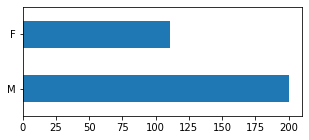

In [0]:
covid['sex'].value_counts().head(30).plot(kind='barh', figsize=(5,2))
#covid['sex'].value_counts(normalize=True).head(30).plot(kind='barh', figsize=(5,2))

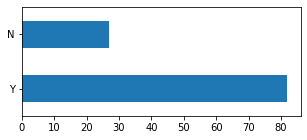

In [0]:
covid['survival'].value_counts().head(30).plot(kind='barh', figsize=(5,2))

O gráfico abaixo mostra que a doença afeta <u>todas as ranges de idade</u>.

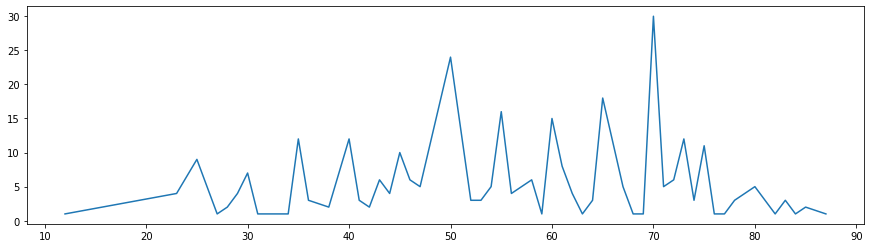

In [0]:
plt.figure(figsize=(15,4))
plt.plot(covid['age'].value_counts().sort_index())

O correlograma abaixo analisa relações entre as variáveis disponibilizadas:

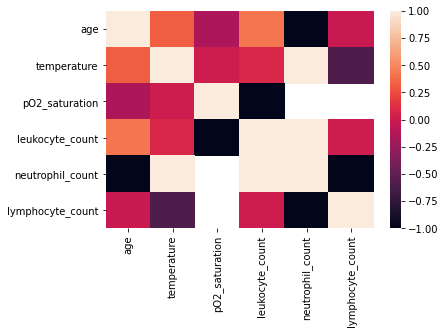

In [0]:
corr = covid.iloc[:,2:].corr()
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns)

Correlação **negativa** entre:

    - idade e neutrófilos
    - temperatura e linfócitos
    - saturação oxigénio e leucócitos
    - neutófilos e linfócitos
    
Correlação positiva entre:

    - temperatura e neutrófilos
    - leucócitos e neutrófilos

O gráfico abaixo mostra uma maior densidade de pacientes entre os 50-80 anos e temperatura a rondar os 38ºC.
No entanto, as temperaturas mais elevadas (40ºC) são experienciadas por indivíduos mais jovens (30-50 anos). Recordamos, no entanto, que o registo da temperatura apresenta muitos MV.

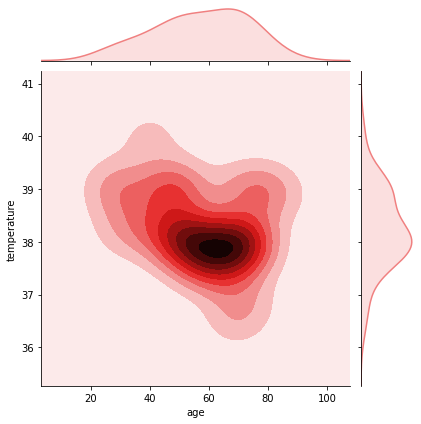

In [0]:
sns.jointplot(x = "age",y = "temperature",data=covid[covid.temperature<=50],kind = "kde",color="lightcoral") # contour plot

Os boxplots abaixo relacionam a **sobrevivência** com o **género** e a idade:
* 50% dos homens (M) que falecem têm idade inferior a 50 anos
* mulheres (F) apresentam uma maior range de idade afetada
* mulheres que falecem apresentam maioritariamente idade avançada (>70 anos)


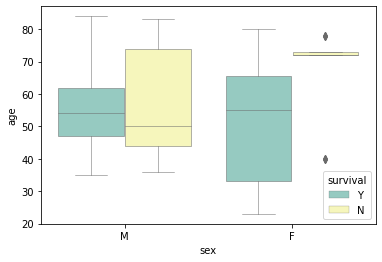

In [0]:
ax = sns.boxplot(y="age", x="sex",hue="survival",data=covid, palette="Set3",linewidth=0.5)

Outra representação que corrobora as conclusões acima
* (cada ponto representa um indivíduo):

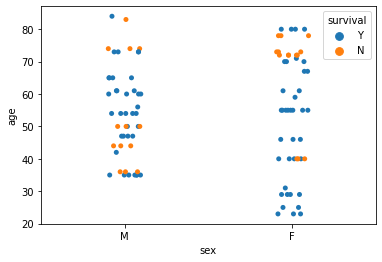

In [0]:
sns.stripplot(x='sex', y='age', data=covid, jitter=True, hue='survival')

O gráfico abaixo evidencia uma necessidade de ventilação:
* ao longo de todas as idades para os homens (M)
* essencialmente acima dos 70 anos para as mulheres (F)

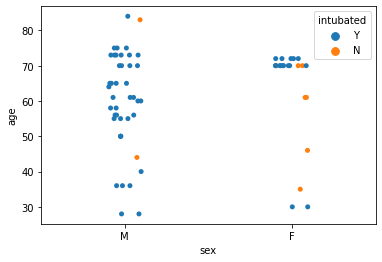

In [0]:
sns.stripplot(x='sex', y='age', data=covid, jitter=True, hue='intubated')

#### 7.2 Visualização das labeles
Após geração de dados COVID-19, as imagens aumentam de 6622 para 8863: os casos COVID-19 passam de 747 para 2988.

Nos dados finais existem <u>4 labels</u> com a seguinte incidência:

In [0]:
def count_labels(y_all):
    how_many_0 = len(np.where(y_all==0)[0])
    how_many_1 = len(np.where(y_all==1)[0])
    how_many_2 = len(np.where(y_all==2)[0])
    how_many_3 = len(np.where(y_all==3)[0])

    print('#covid:',how_many_0)
    print('#viral:',how_many_1)
    print('#bacteria:',how_many_2)
    print('#normal:',how_many_3)
    return how_many_0,how_many_1,how_many_2,how_many_3

#covid: 2988
#viral: 2082
#bacteria: 974
#normal: 2819


Text(0.5, 1.0, '(2988, 2082, 974, 2819)')

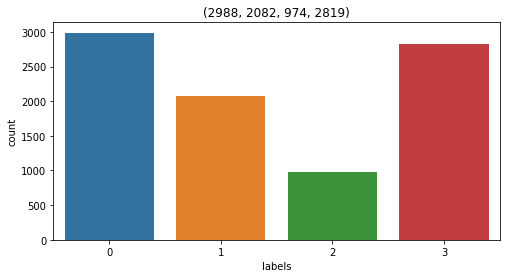

In [0]:
plt.figure(figsize=(8,4))
map_characters = {0: 'COVID-19', 1: 'Viral Pneumonia', 2: 'NORMAL'}
dict_characters=map_characters
df = pd.DataFrame()
df["labels"]=y_all
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab).set_title(count_labels(y_all))

Eventualmente à exceção da classe pneumonia bacteriana, todas as labels estão <u>bem representadas</u> (dados balanceados):

#covid: 2988
#viral: 2082
#bacteria: 974
#normal: 2819


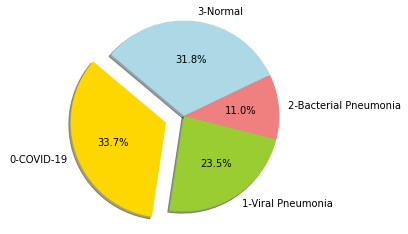

In [0]:
labels = '0-COVID-19', '1-Viral Pneumonia', '2-Bacterial Pneumonia', '3-Normal'
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightblue']
explode = (0.2, 0, 0, 0)  # explode 1st slice
sizes = count_labels(y_all)
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

#### 7.3 Visualização de inputs
As imagens serão transformadas em imagens 200 por 200, gray-scale:

In [0]:
X_all = X_all.reshape(len(y_all),200,200,1)
print('X_all:',X_all.shape)

X_all: (8863, 200, 200, 1)


Nesta secção visualizamos imagens de casos **normais**, casos **covid**, pneumonia **bacteriana** e pneumonia **viral**.

Normal:


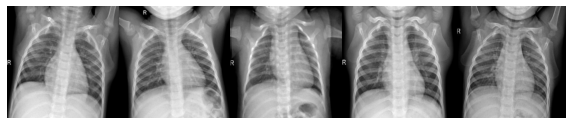

In [0]:
index2=[]
for i in range(0,len(y_all),1):
  if y_all[i] ==3:
    index2.append(i)

plt.subplots_adjust(wspace=0, hspace=0)
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
print('Normal:')
for l in index2[:5]:
    #print(i_)    
    plt.subplot(1,5, i_+1) #.set_title(l)
    i_ += 1
    im = X_all[l]
    im = im[:,:,0]
    plt.imshow(im, cmap="gray")
    plt.axis('off')

COVID-19:


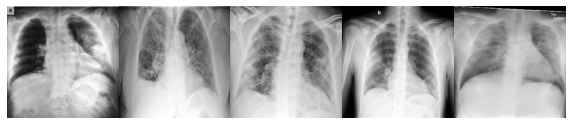

In [0]:
index2=[]
for i in range(0,len(y_all),1):
  if y_all[i] ==0:
    index2.append(i)

plt.subplots_adjust(wspace=0, hspace=0)
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
print('COVID-19:')
for l in index2[:5]:
    #print(i_)    
    plt.subplot(1, 5, i_+1) #.set_title(l)
    i_ += 1
    im = X_all[l]
    im = im[:,:,0]
    plt.imshow(im, cmap="gray")
    plt.axis('off')

Pneumonia viral:


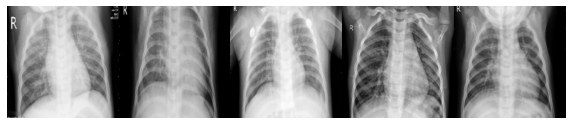

In [0]:
index2=[]
for i in range(0,len(y_all),1):
  if y_all[i] ==1:
    index2.append(i)

plt.subplots_adjust(wspace=0, hspace=0)
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
print('Pneumonia viral:')
for l in index2[:5]:
    #print(i_)    
    plt.subplot(1, 5, i_+1) #.set_title(l)
    i_ += 1
    im = X_all[l]
    im = im[:,:,0]
    plt.imshow(im, cmap="gray")
    plt.axis('off')

Pneumonia bacteriana:


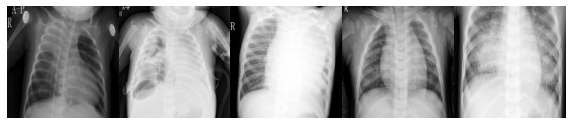

In [0]:
index2=[]
for i in range(0,len(y_all),1):
  if y_all[i] ==2:
    index2.append(i)

plt.subplots_adjust(wspace=0, hspace=0)
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
print('Pneumonia bacteriana:')
for l in index2[:5]:
    #print(i_)    
    plt.subplot(1, 5, i_+1) #.set_title(l)
    i_ += 1
    im = X_all[l]
    im = im[:,:,0]
    plt.imshow(im, cmap="gray")
    plt.axis('off')

### 8. Pré-processamento de dados
Não será efetuada **cross-validation** porque os dados têm dimensão relevante.
Utilização da loss sparse_categorical_entropy revelou-se mais eficaz que a categorização inicial do output.


#### 8.1 Standardização de inputs
As imagens já surgem standardizadas:

In [0]:
# confirm pixel range is 0-255
pixels = np.asarray(X_all)
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
# convert from integers to floats
pixels = pixels.astype('float32')
# a gray-scale image would only have one channel, i.e., 
# it would be a single matrix with pixel values ranging from 0 to 255, with 0 indicating black and 255 indicating white 

Data Type: float64
Min: 0.000, Max: 1.000



#### 8.2 Partição dos dados

* 30% dos dados serão usados para teste
* dos restantes 70%, um sub-grupo de 30% será usado para validação: 21% das imagens para validação e 49% para treino

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = 0.3,random_state=10)

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3,random_state=10)

In [0]:
print('X_train:',X_train.shape)

X_train: (4342, 200, 200, 1)


In [0]:
print('X_test:',X_test.shape)

X_test: (2659, 200, 200, 1)


In [0]:
print('X_val:',X_val.shape)

X_val: (1862, 200, 200, 1)


#### 8.3 Converter output em variável categórica
A utilização da loss sparse_categorical_entropy revelou-se mais eficaz que a categorização inicial do output.

In [0]:
#altenativa ao sparse_categorical_entropy
y_trainCat = to_categorical(y_train)
y_testCat = to_categorical(y_test)
y_valCat = to_categorical(y_val)

# Callbacks definition
early = EarlyStopping(monitor='accuracy', min_delta=0,patience= 5,verbose= True, mode='auto')
#Checkpoint=ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.h5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
LROnPlateau=ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
callbacks = [early,LROnPlateau]

### 9 Definição de funções auxiliares

Começamos por apresentar métricas que enriquecerão o **report** dos modelos:

In [0]:
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 


As seguintes funções avaliam, para cada modelo, a **matriz de confusão**, **métricas de performance** e **plots da loss e accuracy**:

In [0]:
def output_metrics(model,history,X_test, y_test):
   model.save('model.--{epoch:02d}-{val_accuracy:.2f}.h5')
   filename = 'model.--{epoch:02d}-{val_accuracy:.2f}.sav'
   joblib.dump(model, filename)

   cm = confusion_matrix(y_test, np.argmax(model.predict(X_test),axis=1))
   conf_mat=pd.DataFrame(cm)
   conf_mat.index.name='Actual'
   conf_mat.columns.name='Predicted'

   print(conf_mat)
   print('accuracy total:', accuracy(cm))
   print('precision covid:', precision(0,cm))
   print('recall covid:', recall(0,cm))
   print('precision total:', precision_macro_average(cm))
   print('recall total:', recall_macro_average(cm))

   print("label precision recall")
   for label in range(len(unique_labels(y_test))):
    print(f"{label:5d} {precision(label, cm):9.3f} {recall(label, cm):6.3f}")

   results=model.evaluate(X_test, y_test)
   print(results)

   plt.figure(figsize=(12,4))
   plt.subplot(1, 2, 1)
   plt.plot(history.history['accuracy'])
   plt.plot(history.history['val_accuracy'])
   plt.title('Model accuracy')
   plt.ylabel('Accuracy')
   plt.xlabel('Epoch')
   plt.legend(['Train', 'Test'], loc='upper left')
   plt.subplot(1, 2, 2)
   plt.plot(history.history['loss'])
   plt.plot(history.history['val_loss'])
   plt.title('Model loss')
   plt.ylabel('Loss')
   plt.xlabel('Epoch')
   plt.legend(['Train', 'Test'], loc='upper left')
   plt.show()

In [0]:
def output_metrics2(model,history,X_test, y_test):
   model.save('model.--{epoch:02d}-{val_accuracy:.2f}.h5')
   filename = 'model.--{epoch:02d}-{val_accuracy:.2f}.sav'
   joblib.dump(model, filename)

   cm = confusion_matrix(y_test, np.argmax(model.predict(X_test),axis=1))
   conf_mat=pd.DataFrame(cm)
   conf_mat.index.name='Actual'
   conf_mat.columns.name='Predicted'

   print(conf_mat)
   print('accuracy total:', accuracy(cm))
   print('precision covid:', precision(0,cm))
   print('recall covid:', recall(0,cm))
   print('precision total:', precision_macro_average(cm))
   print('recall total:', recall_macro_average(cm))

   print("label precision recall")
   for label in range(len(unique_labels(y_test))):
    print(f"{label:5d} {precision(label, cm):9.3f} {recall(label, cm):6.3f}")

   results=model.evaluate(X_test, y_test)
   print(results)

   plt.figure(figsize=(12,4))
   plt.subplot(1, 2, 1)
   plt.plot(history.history['accuracy'])
   plt.title('Model accuracy')
   plt.ylabel('Accuracy')
   plt.xlabel('Epoch')
   plt.legend(['Train', 'Test'], loc='upper left')
   plt.subplot(1, 2, 2)
   plt.plot(history.history['loss'])
   plt.title('Model loss')
   plt.ylabel('Loss')
   plt.xlabel('Epoch')
   plt.legend(['Train', 'Test'], loc='upper left')
   plt.show()

Especificado um modelo, a seguinte função apresenta detalhe sobre as suas **camadas**:

In [0]:
#plot camadas convolucionais e fully connected

def camadas(model):
  print('Camadas convolucionais:')
  # summarize filter shapes
  for layer in model.layers:
  #check for convolutional layer
      if 'conv' not in layer.name:
          continue   
  # get filter weights
      else:
          filters, biases = layer.get_weights()
          print(layer.name, filters.shape)


  print('Camadas fully connected:')
  # summarize layers shapes
  for layer in model.layers:
  #check for fully conection layer
      if 'dense' not in layer.name:
          continue 
      else:
          filters, biases = layer.get_weights()
          print(layer.name, filters.shape)

  print('imagens saída de Capas Convolucionais:')
  plt.figure(figsize=(20,20))
  # retrieve weights from the second hidden layer
  filters, biases = model.layers[0].get_weights()
  # normalize filter values to 0-1 so we can visualize them
  f_min, f_max = filters.min(), filters.max()
  filters = (filters - f_min) / (f_max - f_min)
  # plot first few filters
  n_filters, ix = 6, 1
  for i in range(n_filters):
  # get the filter
      f = filters[:, :, :, i]
      # plot each channel separately
      for j in range(1):
          # specify subplot and turn of axis
          ax = plt.subplot(n_filters, 3, ix )
          ax.set_xticks([])
          ax.set_yticks([])
          # plot filter channel in grayscale
          plt.imshow(f[:, :, j],cmap='gray')
          ix += 1
  # show the figure
  plt.show()

As funções seguintes apresentam 3 **configurações de redes neuronais CNN**, a testar nas secções seguintes:

In [0]:
def build_model_CNN1(filters, kernel_size,dropout):
  model = models.Sequential()
  model.add(layers.Conv2D(filters, (kernel_size, kernel_size), activation='relu', input_shape=(200, 200, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(filters, (kernel_size, kernel_size), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(filters, (kernel_size, kernel_size), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dropout(dropout))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(16, activation='relu'))
  model.add(layers.Dense(4, activation='softmax'))
  model.compile(optimizers.Adam(lr=0.00001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
  return model

In [0]:
def build_model_CNN2(filters, kernel_size, dropout):
  model = models.Sequential()
  model.add(layers.Conv2D(filters, (kernel_size, kernel_size), activation='relu', input_shape=(200, 200, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(2*filters, (kernel_size, kernel_size), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(4*filters, (kernel_size, kernel_size), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dropout(dropout))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(16, activation='relu'))
  model.add(layers.Dense(4, activation='softmax'))
  model.compile(optimizers.Adam(lr=0.00001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
  return model

In [0]:
def build_model_CNN3():
  #construct CNN structure
  model = Sequential()  
  #1st convolution layer
  model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(200,200,1)))
  model.add(MaxPooling2D(pool_size=(5,5), strides=(2, 2)))
  #2nd convolution layer
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))
  #3rd convolution layer
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))
  
  model.add(Flatten())
  #fully connected neural networks
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(4, activation='softmax'))
  model.compile(optimizers.Adam(lr=0.00001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
  return model

### 10. Machine Learning

Nesta secção são apresentados <u>modelos tradicionais</u> de **machine learning**.
Começamos por colocar as imagens numa lista, de modo a servirem de input para os modelos.

In [0]:
X_all_vec=[]
X_allReshaped = X_all.reshape(len(X_all),200,200)
for i in X_allReshaped:
    img = i
    #print(img.shape)
    cols,colors = img.shape # gives dimensions for RGB array
    img_size = cols*colors
    img_1D_vector = img.reshape(img_size)
    # you can recover the orginal image with:
    img2 = img_1D_vector.reshape(cols,colors)
    X_all_vec.append(img_1D_vector)

In [0]:
len(X_all_vec)

8863

Seguidamente faz-se a partição dos nocos dados em 70% treino e 30% teste:

In [0]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_all_vec,y_all, test_size = 0.3,random_state=10)

#### 10.1 Random Forests
O primeiro modelo de ML a testar é uma Random Forest.

In [0]:
Rfc = RandomForestClassifier(n_estimators = 10, criterion = "entropy", random_state = 42,
                                      min_samples_split=10,min_samples_leaf=1,
                                      max_features='sqrt',max_depth=90,bootstrap=False)

Rfc=Rfc.fit(X_train_3, y_train_3)
y_pred_3  = Rfc.predict(X_test_3)

In [0]:
Accuracy_total_Rfc=Rfc.score(X_test_3, y_test_3)
print('Accuracy total:',Accuracy_total_Rfc)

cm = confusion_matrix(y_test_3, y_pred_3)
conf_mat=pd.DataFrame(cm)
conf_mat.index.name='Actual'
conf_mat.columns.name='Predicted'
print(conf_mat)

print('accuracy total:', accuracy(cm))
print('precision covid:', precision(0,cm))
print('recall covid:', recall(0,cm))
print('precision total:', precision_macro_average(cm))
print('recall total:', recall_macro_average(cm))
print("label precision recall")
for label in range(len(unique_labels(y_test_3))):
 print(f"{label:5d} {precision(label, cm):9.3f} {recall(label, cm):6.3f}")

Accuracy total: 0.8901842798044377
Predicted    0    1    2    3
Actual                       
0          883    5    2    3
1            5  525   46   38
2            1  148  133   14
3            4   23    3  826
accuracy total: 0.8901842798044377
precision covid: 0.9888017917133258
recall covid: 0.9888017917133258
precision total: 0.8495322301596078
recall total: 0.8145320617501352
label precision recall
    0     0.989  0.989
    1     0.749  0.855
    2     0.723  0.449
    3     0.938  0.965


In [0]:
import torch
model_save_name = 'Rfc.sav'
path = F"/content/{model_save_name}" 
torch.save(model_save_name, path)
#classification report
print(classification_report(y_test_3, y_pred_3))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       893
           1       0.75      0.86      0.80       614
           2       0.72      0.45      0.55       296
           3       0.94      0.96      0.95       856

    accuracy                           0.89      2659
   macro avg       0.85      0.81      0.82      2659
weighted avg       0.89      0.89      0.88      2659



In [0]:
import torch
model_save_name = 'Rfc_model.sav'
path = F"/content/{model_save_name}" 
torch.save(Rfc, path)

Conclui-se que o modelo apresenta uma **precisão global de 89%**, identificando **99% dos casos COVID-19**.

O maior erro está associado à pneumonia bacteriana.

#### 10.2 Random Forest: Cross Validation

Apresenta-se nesta secção outra versão de uma **random forest**, mas agora recorrendo a cross-validation com 5 *folds*:

In [0]:
# Modelo 2: Cross Validation
Rfc2 = RandomForestClassifier(n_estimators = 10, criterion = "entropy", random_state = 42,
                                      min_samples_split=10,min_samples_leaf=1,
                                      max_features='sqrt',max_depth=90,bootstrap=False)
scores_rf2 = cross_val_score(Rfc2,X_all_vec, y_all, cv = 5)
scores_rf2_mean=scores_rf2.mean()
model_save_name = 'Rfc2_model.sav'
path = F"/content/{model_save_name}" 
torch.save(Rfc2, path)
print(scores_rf2)
print (scores_rf2_mean)

[0.78341794 0.89791314 0.89340102 0.90688488 0.85665914]
0.8676552221114562


Este modelo apresenta uma **precisão global de 87%**, menor que o modelo anterior, mas mais robusta por usar cross-validation.

#### 10.3 Ensamble-Adaptative Boosting
Esta secção apresenta um modelo de Adaptative Boosting. Este apresenta uma **precisão de apenas 67%**, o que se revela fraca.

In [0]:
#classificações subsequentes são ajustadas a favor das classificadas erradas por classificações anteriores.
#weak learner
#contras: perda da capacidade de generalização após o aprendizado de muitos padrões de treino (overfitting)
ada_tree = AdaBoostClassifier(n_estimators=10)
scores_ada = cross_val_score(ada_tree, X_all_vec, y_all, cv = 5)
scores_ada_mean=scores_ada.mean()
model_save_name = 'ada_tree_model.sav'
path = F"/content/{model_save_name}" 
torch.save(ada_tree, path)
print (scores_ada)
print (scores_ada_mean)

[0.52791878 0.67230682 0.68697124 0.74492099 0.71331828]
0.6690872238327865


#### 10.4 KNN
Apresenta-se nesta secção outra versão de classificaçao ML: KNeighborsClassifier.

In [0]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1,p=1, weights='uniform')


In [0]:
knn_model=knn.fit(X_train_3, y_train_3)
print(knn_model)
Y_pred_test = knn_model.predict(X_test_3)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=1,
                     weights='uniform')


In [0]:
conf_mat=confusion_matrix(y_test_3,knn.predict(X_test_3))
conf_mat=pd.DataFrame(conf_mat)
conf_mat.index.name='Actual'
conf_mat.columns.name='Predicted'
print(conf_mat)

Predicted    0    1    2    3
Actual                       
0          883    5    2    3
1            3  503   78   30
2            0  139  142   15
3            1   39    6  810


In [0]:
knn_model_score=knn_model.score(X_test_3, y_test_3)
model_save_name = 'knn_model.sav'
path = F"/content/{model_save_name}" 
torch.save(knn_model, path)

print('Score:',knn_model_score)

Score: 0.8792779240315908


O modelo apresenta uma precisão de **88%**, comparável com as random forests.

### 11. Modelos deep learning
Esta secção apresenta modelos de **redes neuronais convolucionais** (CNN), historicamente adequadas para a <u>classificação de imagens</u>.

#### 11.1 CNN: label com 4 classes
De seguida são apresentadas 5 versões de CNN para classificar as imagens em:
* 0 - COVID-19
* 1 - Pneumonia viral
* 2 - Pneumonia bacteriana
* 3 - Normal

O primeiro modelo usa 3 camadas convolucionais de 64 filtros e tamanho do núcleo 5, intercaladas com pooling:

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 196, 196, 64)      1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 98, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 94, 94, 64)        102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 47, 47, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 43, 64)        102464    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 28224)            

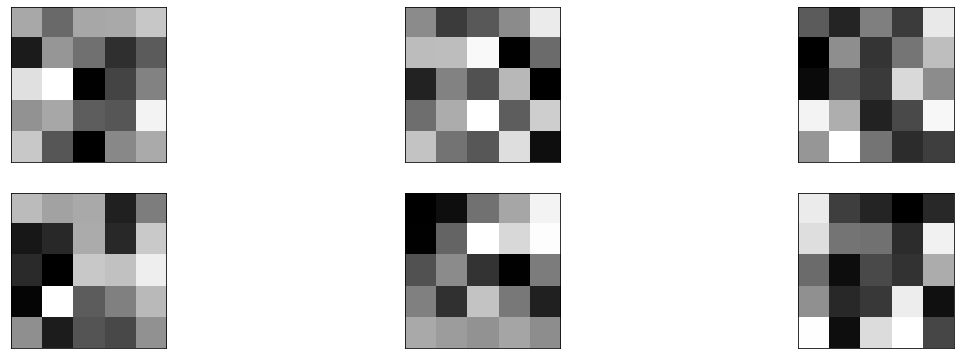

Predicted    0    1    2    3
Actual                       
0          860    7    8   18
1           14  470   78   52
2           10  160  114   12
3            8   25    2  821
accuracy total: 0.8518239939827003
precision covid: 0.9641255605381166
recall covid: 0.9630459126539753
precision total: 0.7869108420778768
recall total: 0.768191377506351
label precision recall
    0     0.964  0.963
    1     0.710  0.765
    2     0.564  0.385
    3     0.909  0.959
2659/2659 [==============================] - 4s 1ms/step
[0.34803070469810893, 0.8518239855766296]


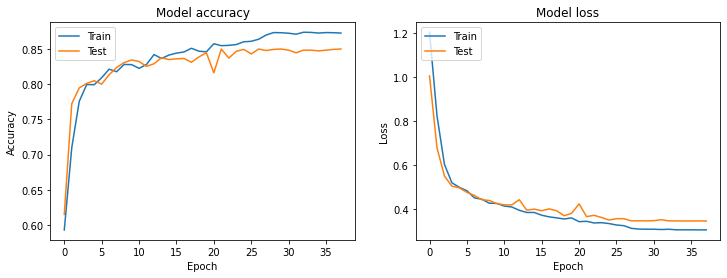

In [0]:
model1=build_model_CNN1(64, 5, 0)
model1.summary()
tf.keras.utils.plot_model(model1, "model1.png", show_shapes = True)
history1=model1.fit(X_train, y_train, epochs=50,validation_data=(X_val,y_val),callbacks = callbacks)
camadas(model1)
output_metrics(model1,history1,X_test, y_test)

import torch
model_save_name = 'model1.sav'
path = F"/content/{model_save_name}" 
torch.save(model1, path)

O modelo atinge uma **precisão global de 85%**, identificando 96**% dos casos COVID-19**.

A matriz de confusão evidencia que o erro está essencialmente associado à capacidade do modelo distinguir pneumonia viral de bacteriana.

Os gráficos convergem após 15 epochs, <u>não revelando overfitting</u> significativo. No entanto, foi testada a seguir uma versão com **50% de dropout**, reduzindo também o tamanho do núcleo de 5 para 3:

Train on 4342 samples, validate on 1862 samples
Epoch 1/50
4342/4342 [==============================] - 19s 4ms/step - loss: 1.2164 - accuracy: 0.4247 - val_loss: 0.9727 - val_accuracy: 0.6122
Epoch 2/50
4342/4342 [==============================] - 17s 4ms/step - loss: 0.8676 - accuracy: 0.6239 - val_loss: 0.7948 - val_accuracy: 0.6160
Epoch 3/50
4342/4342 [==============================] - 17s 4ms/step - loss: 0.7612 - accuracy: 0.6679 - val_loss: 0.7253 - val_accuracy: 0.6472
Epoch 4/50
4342/4342 [==============================] - 17s 4ms/step - loss: 0.6898 - accuracy: 0.7264 - val_loss: 0.6526 - val_accuracy: 0.7750
Epoch 5/50
4342/4342 [==============================] - 17s 4ms/step - loss: 0.6258 - accuracy: 0.7598 - val_loss: 0.5941 - val_accuracy: 0.7852
Epoch 6/50
4342/4342 [==============================] - 17s 4ms/step - loss: 0.5665 - accuracy: 0.7842 - val_loss: 0.5454 - val_accuracy: 0.7863
Epoch 7/50
4342/4342 [==============================] - 17s 4ms/step - loss: 0.523

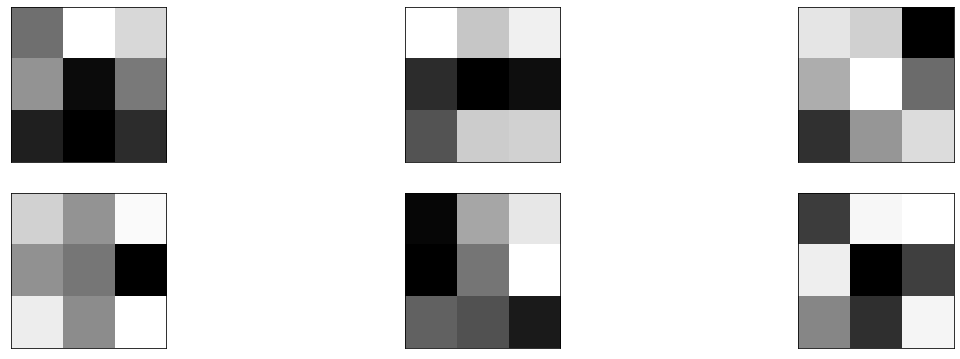

Predicted    0    1   2    3
Actual                      
0          873    9   5    6
1            7  517  51   39
2            1  192  95    8
3            4   39   2  811
accuracy total: 0.86348251222264
precision covid: 0.9864406779661017
recall covid: 0.9776035834266518
precision total: 0.8072430417325986
recall total: 0.7719997449721488
label precision recall
    0     0.986  0.978
    1     0.683  0.842
    2     0.621  0.321
    3     0.939  0.947
2659/2659 [==============================] - 4s 1ms/step
[0.31740251711130857, 0.8634825348854065]


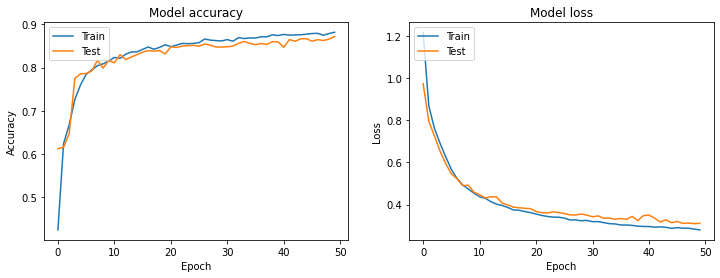

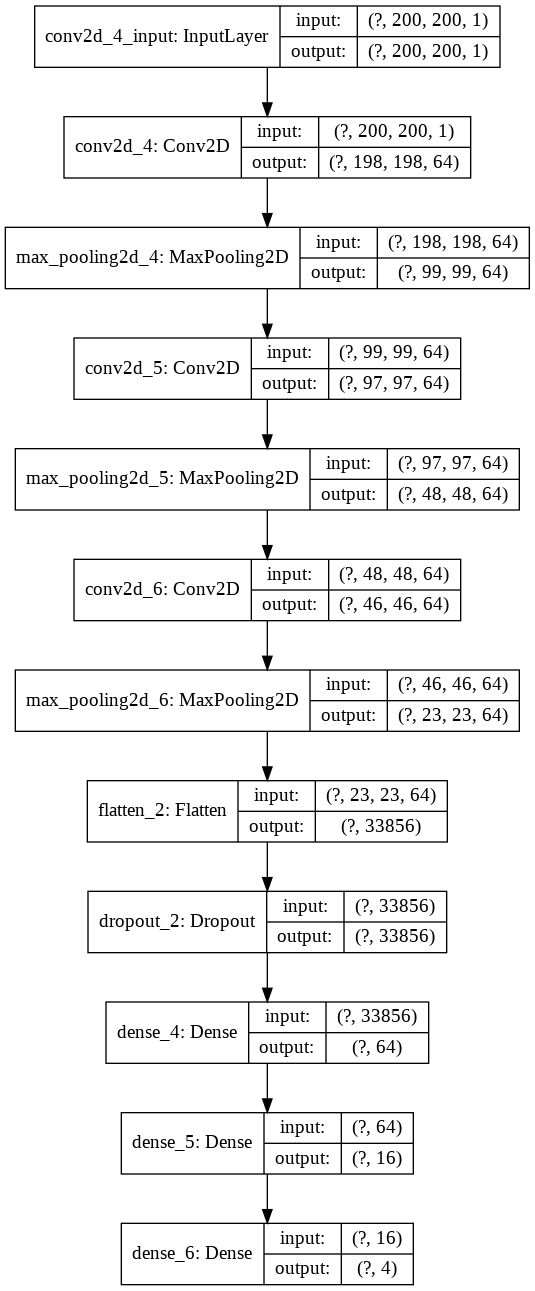

In [0]:
model2=build_model_CNN1(64, 3, 0.5)
history2=model2.fit(X_train, y_train, epochs=50,validation_data=(X_val,y_val))
model2.summary()
camadas(model2)
output_metrics(model2,history2,X_test, y_test)
model_save_name = 'model2.sav'
path = F"/content/{model_save_name}" 
torch.save(model2, path)
tf.keras.utils.plot_model(model2, "model2.png", show_shapes = True)

O modelo atinge uma **precisão global de 86%**, identificando **98% dos casos COVID-19**.
A redução do núcleo revelou-se vantajosa (apesar do dropout), pelo que será usado um <u>núcleo de tamanho 3</u> nos seguintes modelos.

A matriz de confusão evidencia que o erro está essencialmente associado à capacidade do modelo distinguir pneumonia viral de bacteriana.

Os gráficos <u>não revelam overfitting</u>.

---

O modelo seguinte é composto por 3 camadas convolucionais, intercaladas com pooling, mas com filtros distintos: 32, 64 e 128.





Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 198, 198, 32)      320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 67712)            

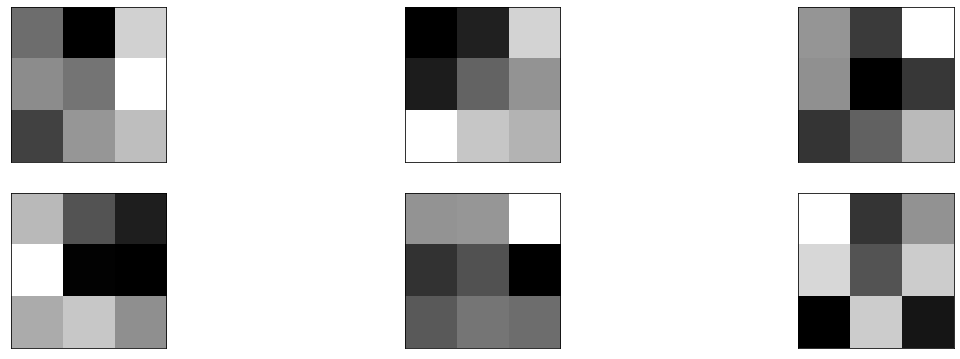

Predicted    0    1    2    3
Actual                       
0          867    9    6   11
1           15  464   88   47
2            7  141  138   10
3            6   33    2  815
accuracy total: 0.8589695374200828
precision covid: 0.9687150837988827
recall covid: 0.9708846584546472
precision total: 0.7996511465293638
recall total: 0.78622600103552
label precision recall
    0     0.969  0.971
    1     0.717  0.756
    2     0.590  0.466
    3     0.923  0.952
2659/2659 [==============================] - 3s 1ms/step
[0.3390269174796381, 0.858969509601593]


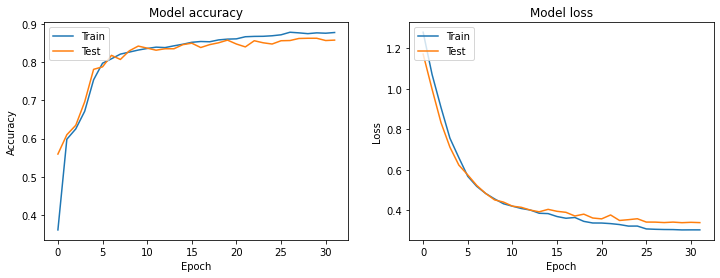

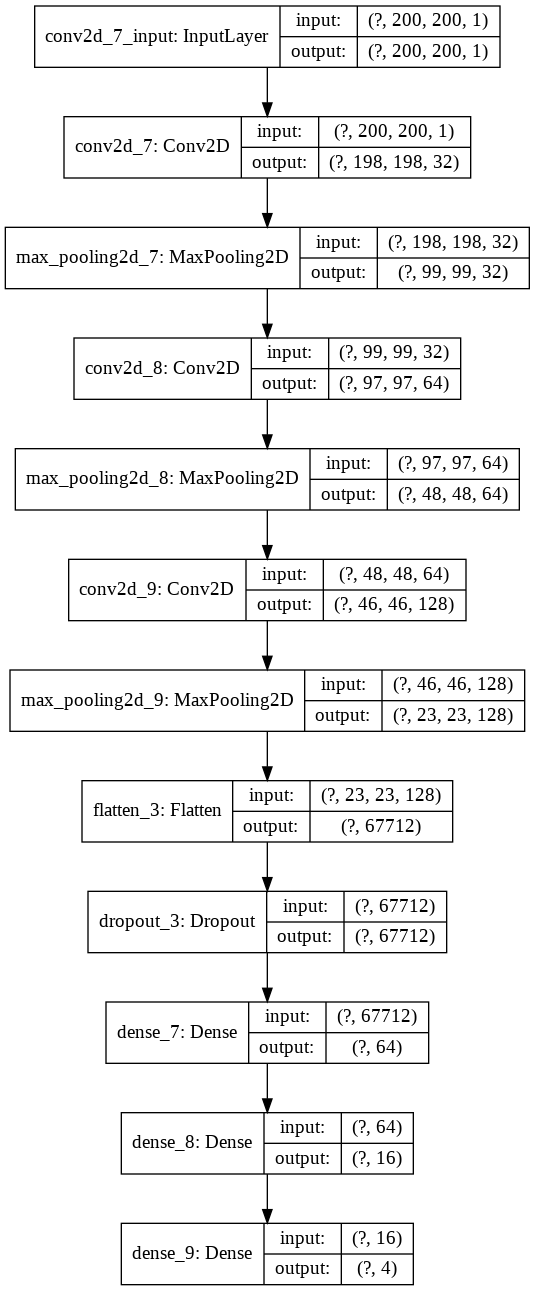

In [0]:
model3=build_model_CNN2(32,3,0)
model3.summary()
history3=model3.fit(X_train, y_train, epochs=50,validation_data=(X_val,y_val),callbacks = callbacks)
camadas(model3)
output_metrics(model3,history3,X_test, y_test)
model_save_name = 'model3.sav'
path = F"/content/{model_save_name}" 
torch.save(model3, path)
tf.keras.utils.plot_model(model3, "model3.png", show_shapes = True)

O modelo atinge uma **precisão global de 86%**, identificando **97% dos casos COVID-19**.

Mais uma vez, a matriz de confusão evidencia que o erro está essencialmente associado à capacidade do modelo distinguir pneumonia viral de bacteriana.

Os gráficos <u>revelam ligeiro overfitting</u>, convergindo após 15 epochs.

---
O quarto modelo pretende <u>controlar o ligeiro overfitting</u> do modelo anterior, incluindo uma camada de **dropout** de 20%:



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 198, 198, 32)      320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 46, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 23, 23, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 67712)            

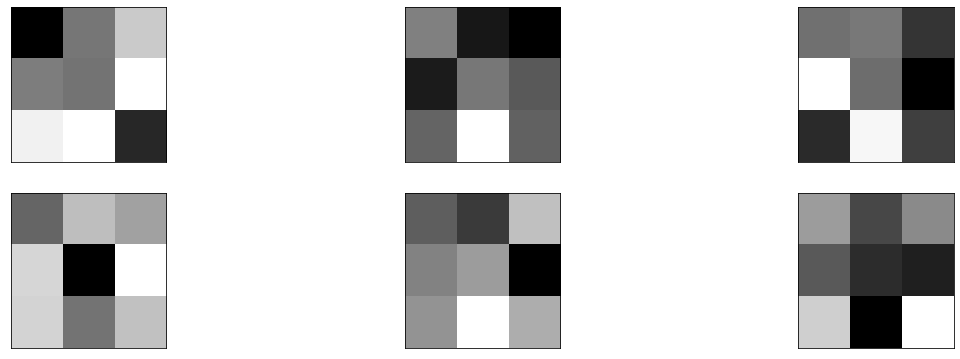

Predicted    0    1    2    3
Actual                       
0          871   10    6    6
1           12  491   72   39
2            8  159  119   10
3            6   28    1  821
accuracy total: 0.8657389996239188
precision covid: 0.9710144927536232
recall covid: 0.975363941769317
precision total: 0.8057254990833863
recall total: 0.784044346357508
label precision recall
    0     0.971  0.975
    1     0.714  0.800
    2     0.601  0.402
    3     0.937  0.959
2659/2659 [==============================] - 3s 1ms/step
[0.3254942063714338, 0.8657389879226685]


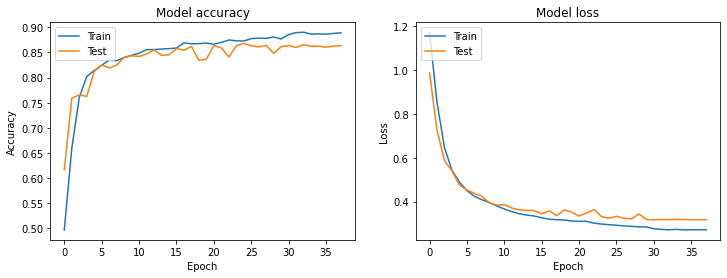

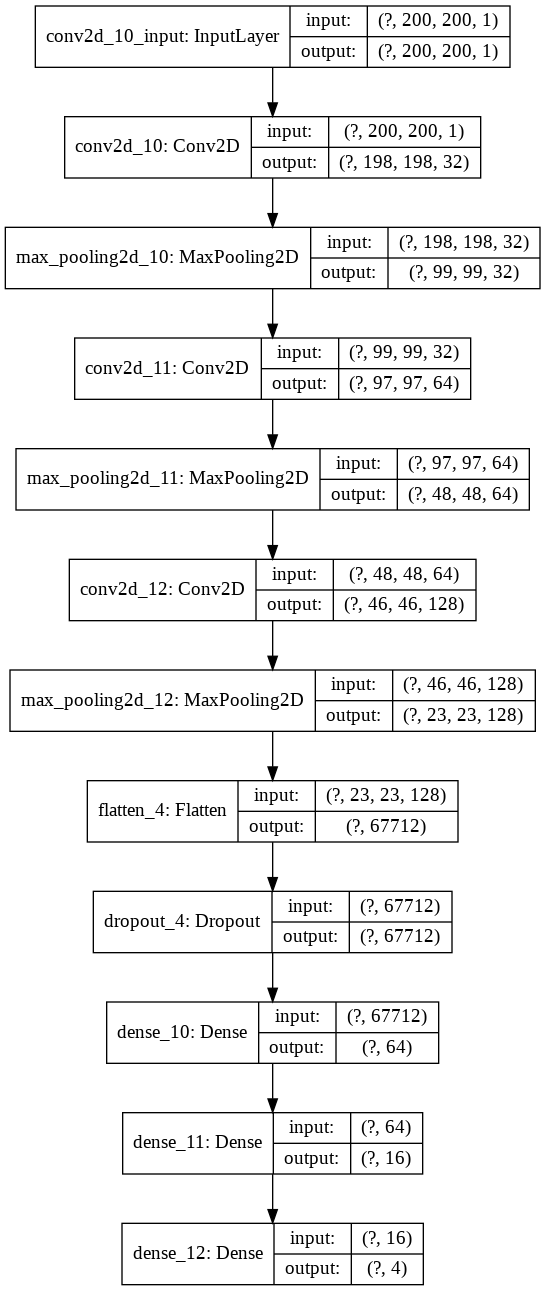

In [0]:
model4=build_model_CNN2(32,3,0.2)
model4.summary()
history4=model4.fit(X_train, y_train, epochs=50,validation_data=(X_val,y_val),callbacks = callbacks)
camadas(model4)
output_metrics(model4,history4,X_test, y_test)
model_save_name = 'model4.sav'
path = F"/content/{model_save_name}" 
torch.save(model4, path)
tf.keras.utils.plot_model(model4, "model4.png", show_shapes = True)
#batch_size=512
#83%+83%

Não se verificam diferenças com a camada de dropout em relação à versão anterior.

---


O próximo modelo é um pouco **mais complexo**. Começa por uma camada convolucional de 64 filtros, seguida de pooling, depois 2 camadas convolucionais de 64 filtros seguidas de pooling e, por fim, 2 camadas convolucionais de 128  filtros, seguida de pooling. Não apresenta controlo de overfitting.



Train on 4342 samples, validate on 1862 samples
Epoch 1/50
4342/4342 [==============================] - 38s 9ms/step - loss: 1.0581 - accuracy: 0.5495 - val_loss: 0.7906 - val_accuracy: 0.7374
Epoch 2/50
4342/4342 [==============================] - 36s 8ms/step - loss: 0.6607 - accuracy: 0.7266 - val_loss: 0.5652 - val_accuracy: 0.7750
Epoch 3/50
4342/4342 [==============================] - 36s 8ms/step - loss: 0.5462 - accuracy: 0.7789 - val_loss: 0.4885 - val_accuracy: 0.8067
Epoch 4/50
4342/4342 [==============================] - 36s 8ms/step - loss: 0.4874 - accuracy: 0.7948 - val_loss: 0.4695 - val_accuracy: 0.8126
Epoch 5/50
4342/4342 [==============================] - 36s 8ms/step - loss: 0.4539 - accuracy: 0.8070 - val_loss: 0.4293 - val_accuracy: 0.8206
Epoch 6/50
4342/4342 [==============================] - 36s 8ms/step - loss: 0.4254 - accuracy: 0.8185 - val_loss: 0.4488 - val_accuracy: 0.8195
Epoch 7/50
4342/4342 [==============================] - 36s 8ms/step - loss: 0.407

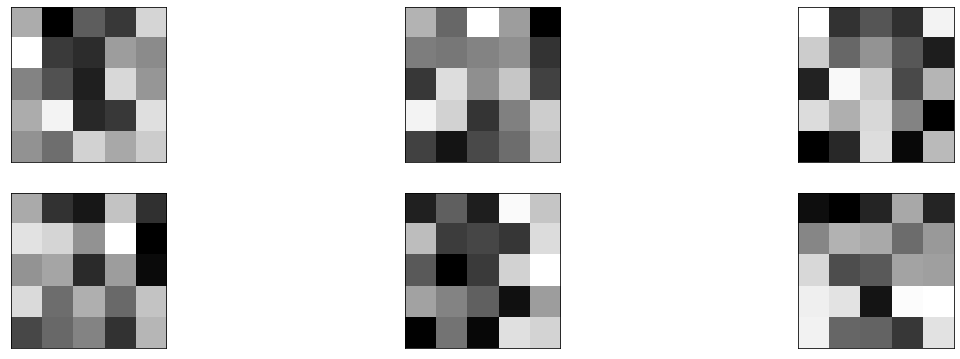

Predicted    0    1    2    3
Actual                       
0          883    2    5    3
1            4  487   96   27
2            3  130  156    7
3            3   24    4  825
accuracy total: 0.8841669800676947
precision covid: 0.9888017917133258
recall covid: 0.9888017917133258
precision total: 0.8252416886355715
recall total: 0.8181933686474615
label precision recall
    0     0.989  0.989
    1     0.757  0.793
    2     0.598  0.527
    3     0.957  0.964
2659/2659 [==============================] - 6s 2ms/step
[0.29708418118178664, 0.884166955947876]


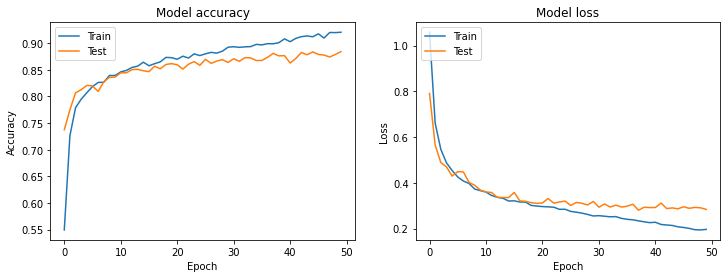

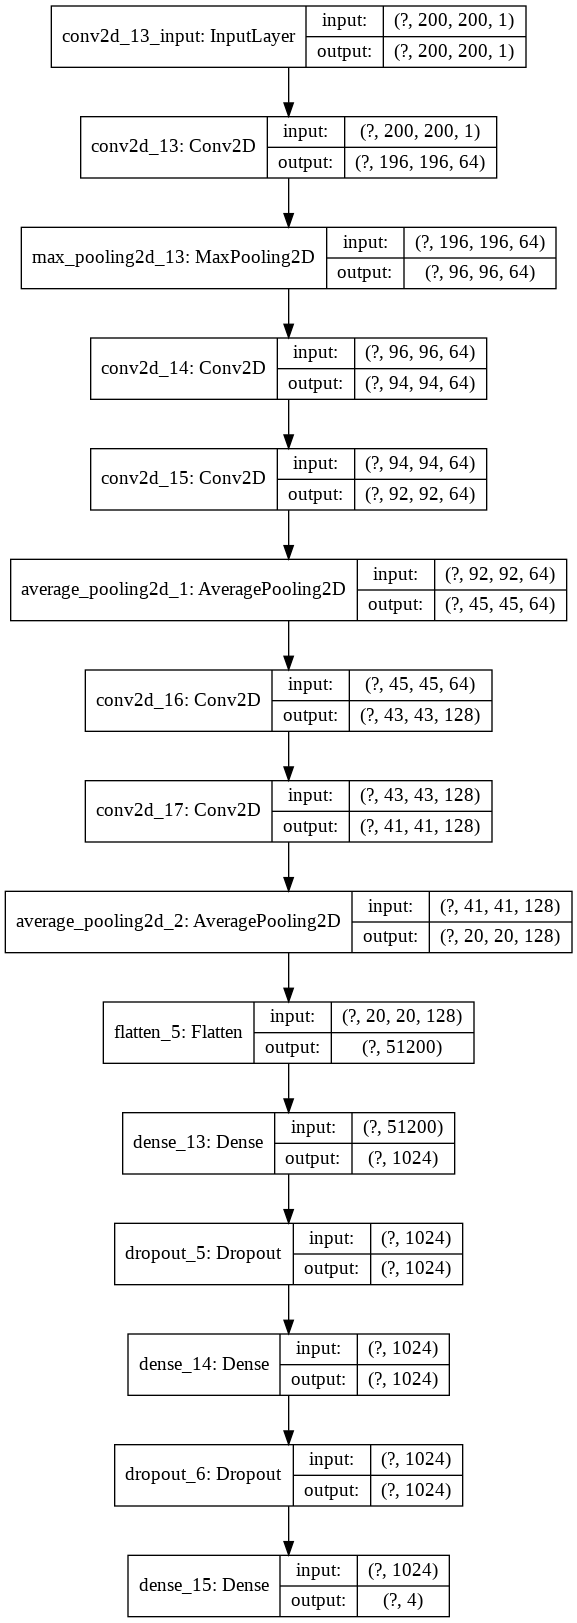

In [0]:
model5=build_model_CNN3()
history5=model5.fit(X_train, y_train, epochs=50,validation_data=(X_val,y_val),callbacks = callbacks)
model5.summary()
camadas(model5)
output_metrics(model5,history5,X_test, y_test)
model_save_name = 'model5.sav'
path = F"/content/{model_save_name}" 
torch.save(model5, path)
tf.keras.utils.plot_model(model5, "model5.png", show_shapes = True)

O modelo tem uma performance aglobal de **88%**, mantendo a identificação de **99% dos casos COVID-19**.

Mais uma vez, o erro está essencialmente associado à capacidade do modelo distinguir pneumonia viral de bacteriana.

Os gráficos apresentam, no entanto, <u>overfitting</u> após 15 epochs.


#### 11.2 API funcional

In [0]:
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D,AveragePooling2D
from keras.layers.merge import concatenate

def build_model_CNN_API_1():
  visible = Input(shape=(200,200,1))
  # first feature extractor
  conv1 = Conv2D(64, kernel_size=4, activation='relu')(visible)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(64, kernel_size=4, activation='relu')(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(64, kernel_size=4, activation='relu')(pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  flat1 = Flatten()(pool3)
  # second feature extractor

  conv2_1 = Conv2D(32, kernel_size=4, activation='relu')(visible)
  pool2_1 = AveragePooling2D(pool_size=(2, 2))(conv2_1)
  conv2_2 = Conv2D(32, kernel_size=4, activation='relu')(pool2_1)
  pool2_2 = AveragePooling2D(pool_size=(2, 2))(conv2_2)
  conv2_3 = Conv2D(32, kernel_size=4, activation='relu')(pool2_2)
  pool2_2 = AveragePooling2D(pool_size=(2, 2))(conv2_3)
  flat2 = Flatten()(pool2_2)
  # merge feature extractors
  merge = concatenate([flat1, flat2])
  # interpretation layer
  hidden1 = Dense(128, activation='relu')(merge)
  hidden2 = Dense(64, activation='relu')(hidden1)
  hidden3 = Dense(32, activation='relu')(hidden2)    
  # prediction output
  output = Dense(4, activation='sigmoid')(hidden3)
  model = Model(inputs=visible, outputs=output)
  model.compile(optimizers.Adam(lr=0.00001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
  return model

Train on 4342 samples, validate on 1862 samples
Epoch 1/50
4342/4342 [==============================] - 33s 8ms/step - loss: 1.2499 - accuracy: 0.5085 - val_loss: 1.0912 - val_accuracy: 0.5580
Epoch 2/50
4342/4342 [==============================] - 31s 7ms/step - loss: 0.8028 - accuracy: 0.7013 - val_loss: 0.6265 - val_accuracy: 0.7137
Epoch 3/50
4342/4342 [==============================] - 31s 7ms/step - loss: 0.5404 - accuracy: 0.7856 - val_loss: 0.5050 - val_accuracy: 0.8024
Epoch 4/50
4342/4342 [==============================] - 31s 7ms/step - loss: 0.4835 - accuracy: 0.8033 - val_loss: 0.4935 - val_accuracy: 0.7965
Epoch 5/50
4342/4342 [==============================] - 31s 7ms/step - loss: 0.4555 - accuracy: 0.8176 - val_loss: 0.4681 - val_accuracy: 0.8008
Epoch 6/50
4342/4342 [==============================] - 31s 7ms/step - loss: 0.4261 - accuracy: 0.8310 - val_loss: 0.4249 - val_accuracy: 0.8260
Epoch 7/50
4342/4342 [==============================] - 31s 7ms/step - loss: 0.416

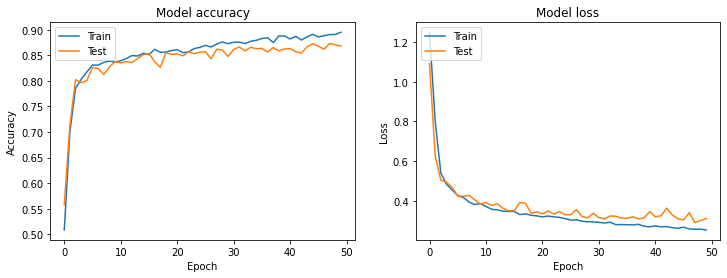

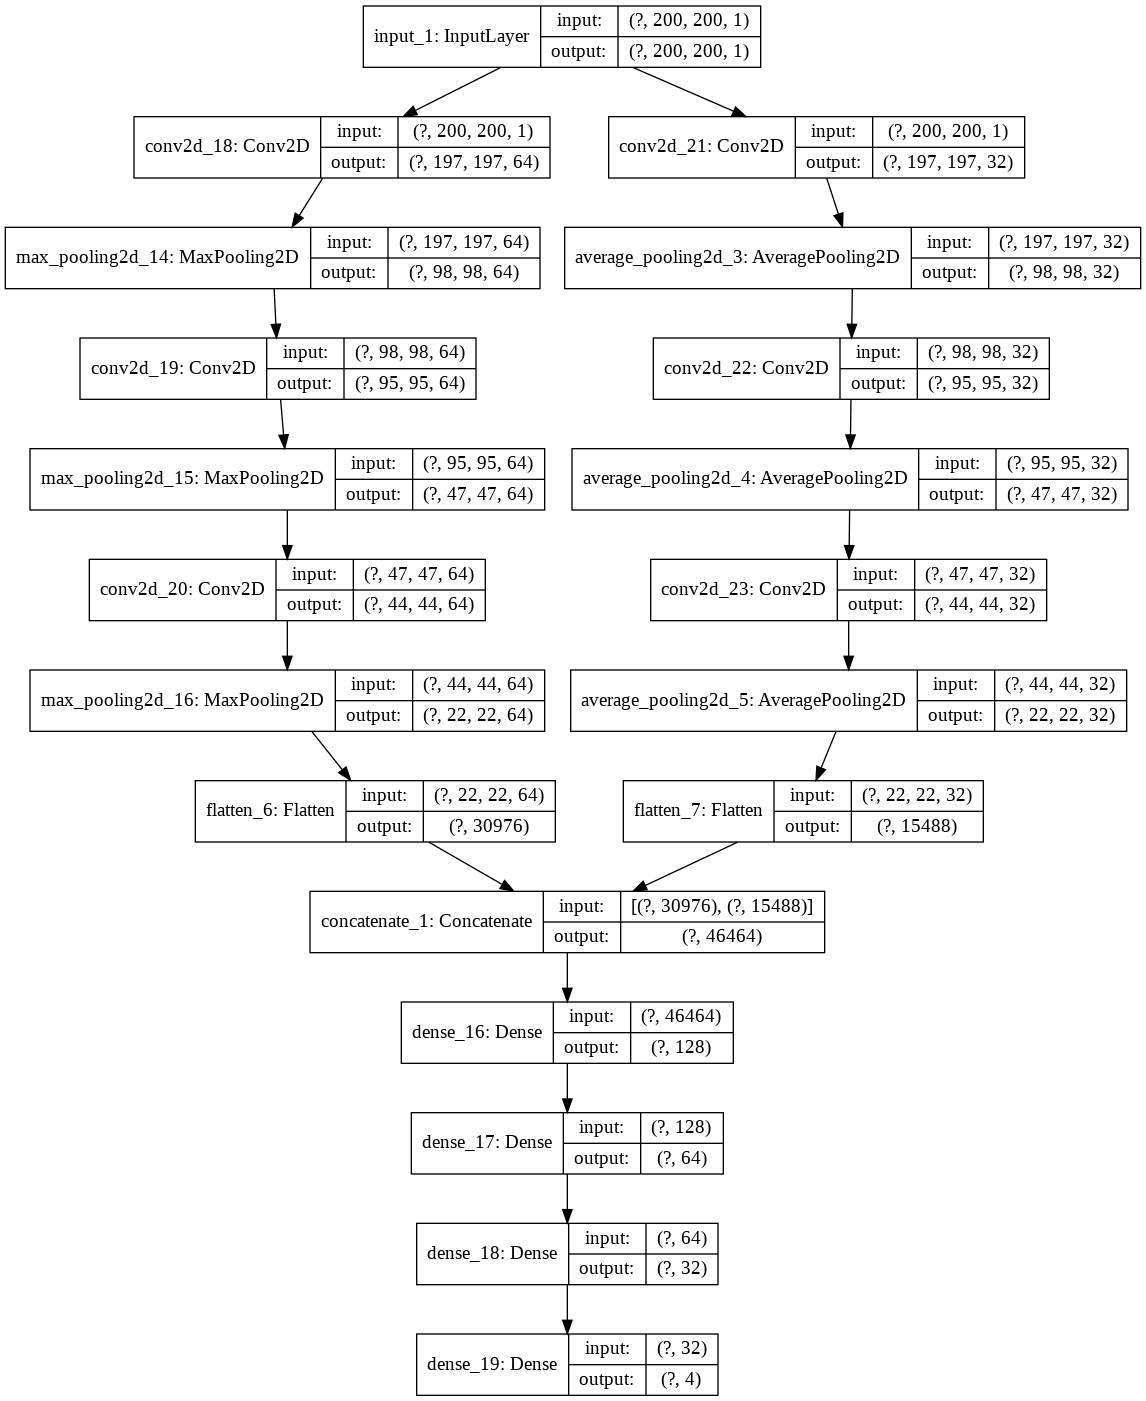

In [0]:
model_CNN_API_1=build_model_CNN_API_1()
history_model_CNN_API_1=model_CNN_API_1.fit(X_train, y_train, epochs=50,validation_data=(X_val,y_val))
model_CNN_API_1.summary()
#camadas(model_CNN_API_1)
output_metrics(model_CNN_API_1,history_model_CNN_API_1,X_test, y_test)
model_save_name = 'model_CNN_API_1.sav'
path = F"/content/{model_save_name}" 
torch.save(model_CNN_API_1, path)
tf.keras.utils.plot_model(model_CNN_API_1, "model_CNN_API_1.png", show_shapes = True)

Testan-se adicionalmente 2 redes, usando a API funcional:

In [0]:
def build_model_CNN_API_2():
  visible = Input(shape=(200,200,1))
  # first feature extractor
  conv1 = Conv2D(64, kernel_size=4, activation='relu')(visible)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(64, kernel_size=4, activation='relu')(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(64, kernel_size=4, activation='relu')(pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  flat1 = Flatten()(pool3)
  # second feature extractor

  conv2_1 = Conv2D(32, kernel_size=4, activation='relu')(visible)
  pool2_1 = AveragePooling2D(pool_size=(2, 2))(conv2_1)
  conv2_2 = Conv2D(32, kernel_size=4, activation='relu')(pool2_1)
  pool2_2 = AveragePooling2D(pool_size=(2, 2))(conv2_2)
  conv2_3 = Conv2D(32, kernel_size=4, activation='relu')(pool2_2)
  pool2_2 = AveragePooling2D(pool_size=(2, 2))(conv2_3)
  flat2 = Flatten()(pool2_2)
  # merge feature extractors
  merge = concatenate([flat1, flat2])
  # interpretation layer
  hidden1 = Dense(128, activation='relu')(merge)
  hidden2 = Dense(64, activation='relu',)(hidden1)
  hidden3 = Dense(32, activation='relu')(hidden2)
  hidden4 = Dense(16, activation='relu')(hidden3)
  hidden5 = Dense(32, activation='relu')(hidden4)
  hidden6 = Dense(16, activation='relu')(hidden5)
  hidden7 = Dense(8, activation='relu')(hidden6)

  hidden1_1 = Dense(128, activation='relu')(merge)
  hidden2_1 = Dense(64, activation='relu')(hidden1_1)
  hidden3_1 = Dense(32, activation='relu')(hidden2_1)
  hidden4_1 = Dense(32, activation='relu')(hidden3_1)

  concatenated = concatenate([hidden3, hidden4_1])

  output = Dense(4, activation='sigmoid')(concatenated)
  model = Model(inputs=visible, outputs=output)
  model.compile(optimizers.Adam(lr=0.00001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
  return model

Train on 4342 samples, validate on 1862 samples
Epoch 1/50
4342/4342 [==============================] - 33s 8ms/step - loss: 1.2267 - accuracy: 0.4496 - val_loss: 1.0276 - val_accuracy: 0.6149
Epoch 2/50
4342/4342 [==============================] - 32s 7ms/step - loss: 0.7550 - accuracy: 0.7319 - val_loss: 0.5860 - val_accuracy: 0.7879
Epoch 3/50
4342/4342 [==============================] - 33s 8ms/step - loss: 0.5336 - accuracy: 0.7886 - val_loss: 0.5845 - val_accuracy: 0.7282
Epoch 4/50
4342/4342 [==============================] - 33s 8ms/step - loss: 0.4846 - accuracy: 0.8024 - val_loss: 0.4911 - val_accuracy: 0.7895
Epoch 5/50
4342/4342 [==============================] - 33s 8ms/step - loss: 0.4511 - accuracy: 0.8148 - val_loss: 0.4640 - val_accuracy: 0.8104
Epoch 6/50
4342/4342 [==============================] - 33s 8ms/step - loss: 0.4320 - accuracy: 0.8213 - val_loss: 0.4278 - val_accuracy: 0.8217
Epoch 7/50
4342/4342 [==============================] - 33s 8ms/step - loss: 0.411

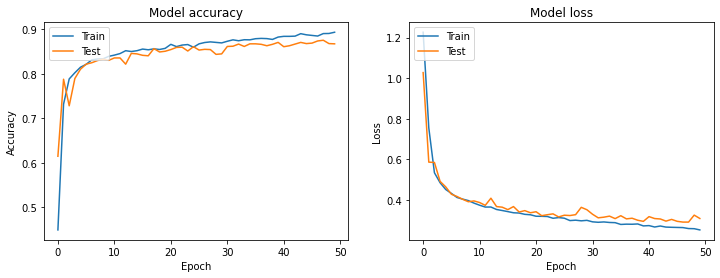

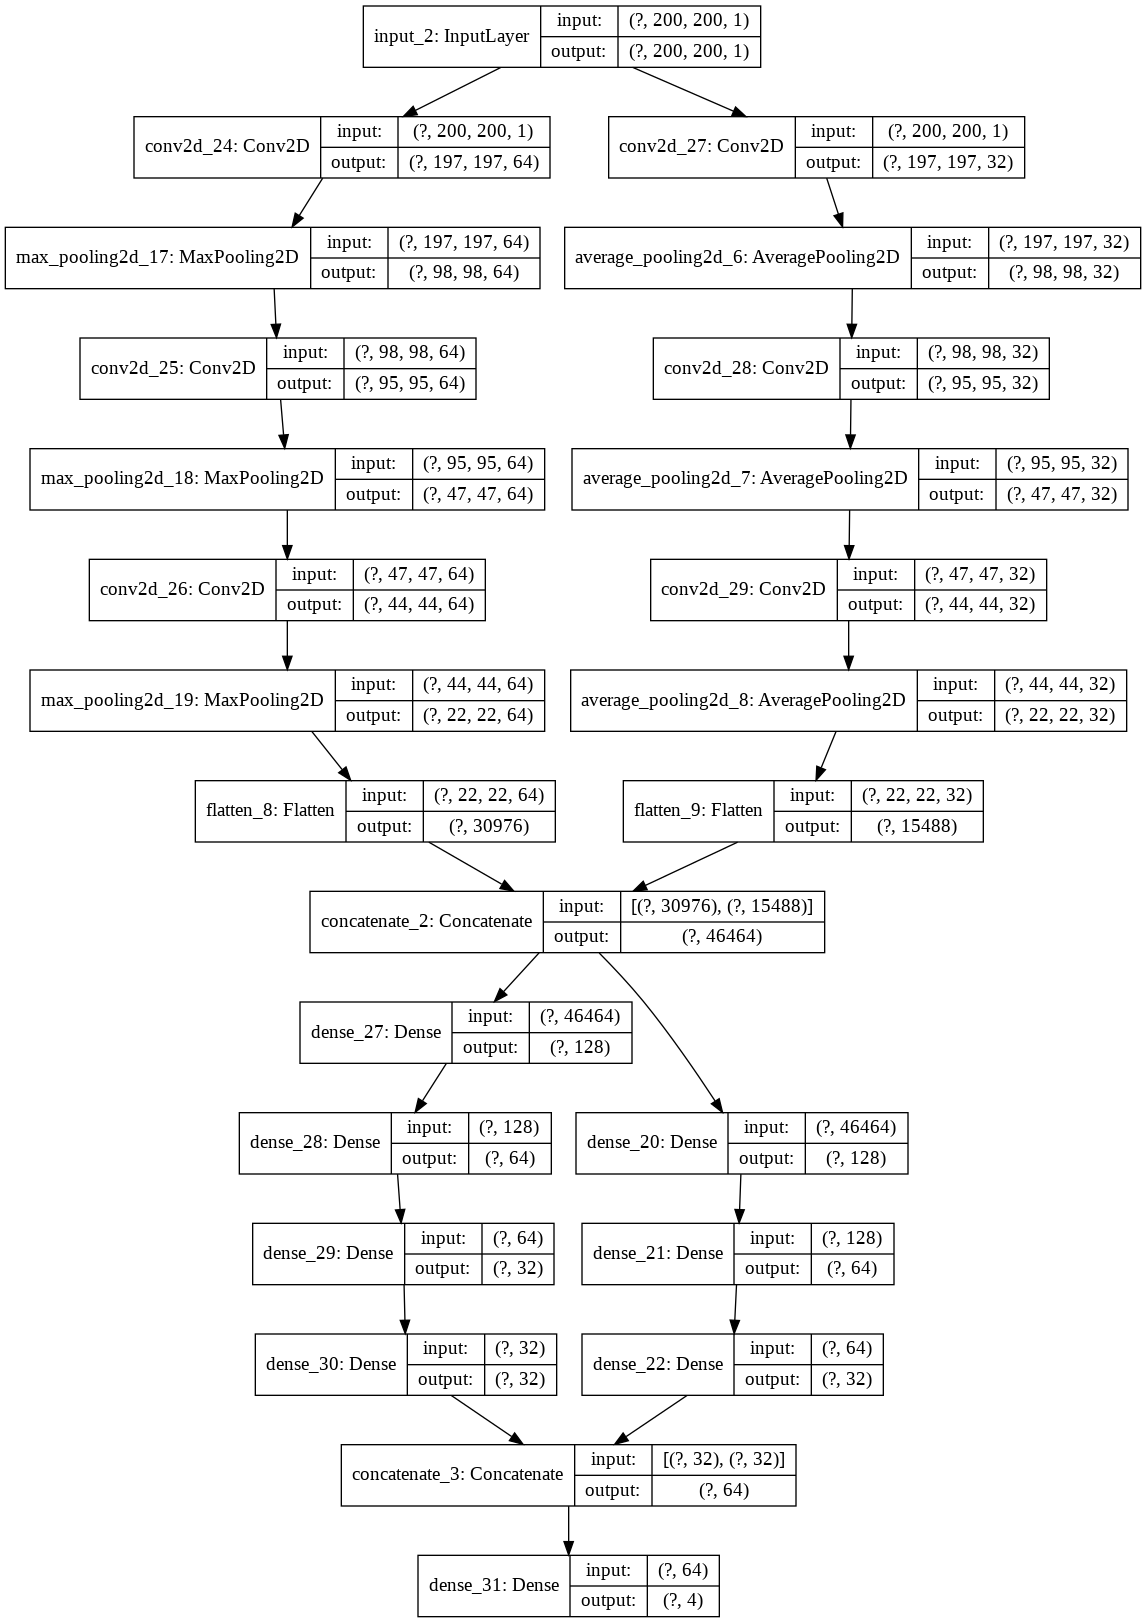

In [0]:
model_CNN_API_2=build_model_CNN_API_2()
history_model_CNN_API_2=model_CNN_API_2.fit(X_train, y_train, epochs=50,validation_data=(X_val,y_val))
model_CNN_API_2.summary()
#camadas(model_CNN_API_2)
output_metrics(model_CNN_API_2,history_model_CNN_API_2,X_test, y_test)
model_save_name = 'model_CNN_API_2.sav'
path = F"/content/{model_save_name}" 
torch.save(model_CNN_API_2, path)
tf.keras.utils.plot_model(model_CNN_API_2, "model_CNN_API_2.png", show_shapes = True)

Os resultados obtidos estão em linha com as CNN anteriormente testadas, rondando os 87% de accuracy global.

#### 11.3 CNN: label com 3 classes

Como o maior erro está associado à dificuldade de separação entre pneumonia viral e bacteriana, e não sendo este o objetivo principal do trabalho, trinam-se nesta secção modelos que visam classificar as imagens em 3 grupos:
* 0- Covid-19
* 1- Outra pneumonia (viral ou bacteriana)
* 2- Normal

In [0]:
unique_labels(y_all)

array([0, 1, 2, 3])

In [0]:
y_all2=y_all.copy()
for i in range(1,len(y_all),1):
  if y_all[i]==1: y_all2[i]=2
unique_labels(y_all2)

array([0, 2, 3])

In [0]:
how_many_0 = len(np.where(y_all2==0.)[0])
how_many_1 = len(np.where(y_all2==1.)[0])
how_many_2 = len(np.where(y_all2==2.)[0])
how_many_3 = len(np.where(y_all2==3.)[0])
print('#covid:',how_many_0)
print('#viral:',how_many_1)
print('#bacteria:',how_many_2)
print('#normal:',how_many_3)

#covid: 2988
#viral: 0
#bacteria: 3056
#normal: 2819


Para os novos dados (labels), são redefinidas os conjuntos de treino, validação e teste:

In [0]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_all, y_all2, test_size = 0.3,random_state=10)
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size = 0.3,random_state=10)

O modelo seguinte é uma CNN com camadas convolucionais de 64 filtros, intercaladas com camadas de pooling. Não são usadas camadas de dropout.

Train on 4342 samples, validate on 1862 samples
Epoch 1/50
4342/4342 [==============================] - 27s 6ms/step - loss: 1.2443 - accuracy: 0.3611 - val_loss: 0.9479 - val_accuracy: 0.7787
Epoch 2/50
4342/4342 [==============================] - 19s 4ms/step - loss: 0.5926 - accuracy: 0.8079 - val_loss: 0.3889 - val_accuracy: 0.8738
Epoch 3/50
4342/4342 [==============================] - 19s 4ms/step - loss: 0.3645 - accuracy: 0.8699 - val_loss: 0.3802 - val_accuracy: 0.8443
Epoch 4/50
4342/4342 [==============================] - 19s 4ms/step - loss: 0.3088 - accuracy: 0.8952 - val_loss: 0.2846 - val_accuracy: 0.8974
Epoch 5/50
4342/4342 [==============================] - 19s 4ms/step - loss: 0.2766 - accuracy: 0.9067 - val_loss: 0.2717 - val_accuracy: 0.9092
Epoch 6/50
4342/4342 [==============================] - 19s 4ms/step - loss: 0.2505 - accuracy: 0.9162 - val_loss: 0.2408 - val_accuracy: 0.9135
Epoch 7/50
4342/4342 [==============================] - 19s 4ms/step - loss: 0.239

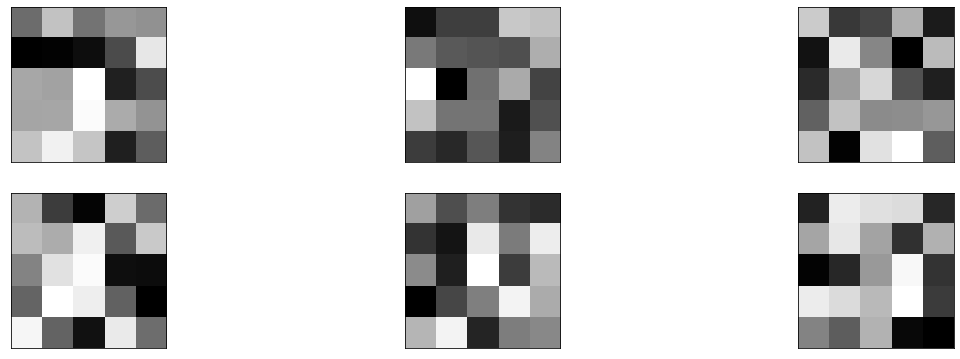

Predicted    0    1    2
Actual                  
0          872   15    6
1           21  867   22
2            8   54  794
accuracy total: 0.9526137645731478
precision covid: 0.9678135405105438
recall covid: 0.9764837625979843
precision total: 0.9533441104839874
recall total: 0.952267036267727
label precision recall
    0     0.968  0.976
    1     0.926  0.953
    2     0.966  0.928
2659/2659 [==============================] - 4s 2ms/step
[0.13433945338140532, 0.9526137709617615]


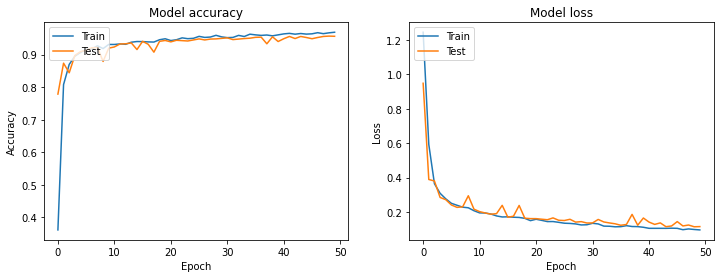

In [0]:
model6=build_model_CNN1(64, 5, 0)
history6=model6.fit(X_train2, y_train2, epochs=50,validation_data=(X_val2,y_val2))
model6.summary()
tf.keras.utils.plot_model(model6, "model6.png", show_shapes = True)
camadas(model6)
output_metrics(model6,history6,X_test2, y_test2)
model_save_name = 'model6_3.sav'
path = F"/content/{model_save_name}" 
torch.save(model6, path)

Com a agregação das pneumonias viral e bacteriana numa única classe, a **performance global aumenta para 95%**. Os gráficos da precisão e loss <u>não evidenciam overfitting</u> significativo.

Train on 4342 samples, validate on 1862 samples
Epoch 1/50
4342/4342 [==============================] - 19s 4ms/step - loss: 1.0772 - accuracy: 0.5691 - val_loss: 0.7137 - val_accuracy: 0.7621
Epoch 2/50
4342/4342 [==============================] - 17s 4ms/step - loss: 0.5749 - accuracy: 0.7870 - val_loss: 0.4424 - val_accuracy: 0.8765
Epoch 3/50
4342/4342 [==============================] - 17s 4ms/step - loss: 0.4106 - accuracy: 0.8544 - val_loss: 0.3453 - val_accuracy: 0.8915
Epoch 4/50
4342/4342 [==============================] - 17s 4ms/step - loss: 0.3314 - accuracy: 0.8812 - val_loss: 0.2941 - val_accuracy: 0.9060
Epoch 5/50
4342/4342 [==============================] - 17s 4ms/step - loss: 0.2944 - accuracy: 0.8952 - val_loss: 0.2662 - val_accuracy: 0.9141
Epoch 6/50
4342/4342 [==============================] - 17s 4ms/step - loss: 0.2621 - accuracy: 0.9083 - val_loss: 0.2442 - val_accuracy: 0.9205
Epoch 7/50
4342/4342 [==============================] - 17s 4ms/step - loss: 0.249

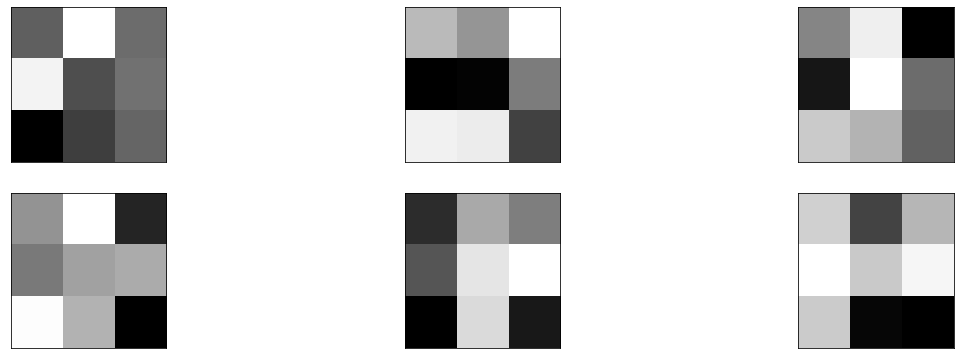

Predicted    0    1    2
Actual                  
0          873   13    7
1           16  826   68
2            3   14  839
accuracy total: 0.95449417074088
precision covid: 0.9786995515695067
recall covid: 0.9776035834266518
precision total: 0.95499655644717
recall total: 0.9551453593449492
label precision recall
    0     0.979  0.978
    1     0.968  0.908
    2     0.918  0.980
2659/2659 [==============================] - 4s 1ms/step
[0.13941396868970887, 0.9544941782951355]


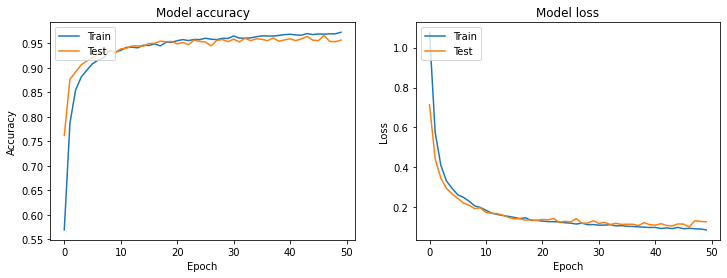

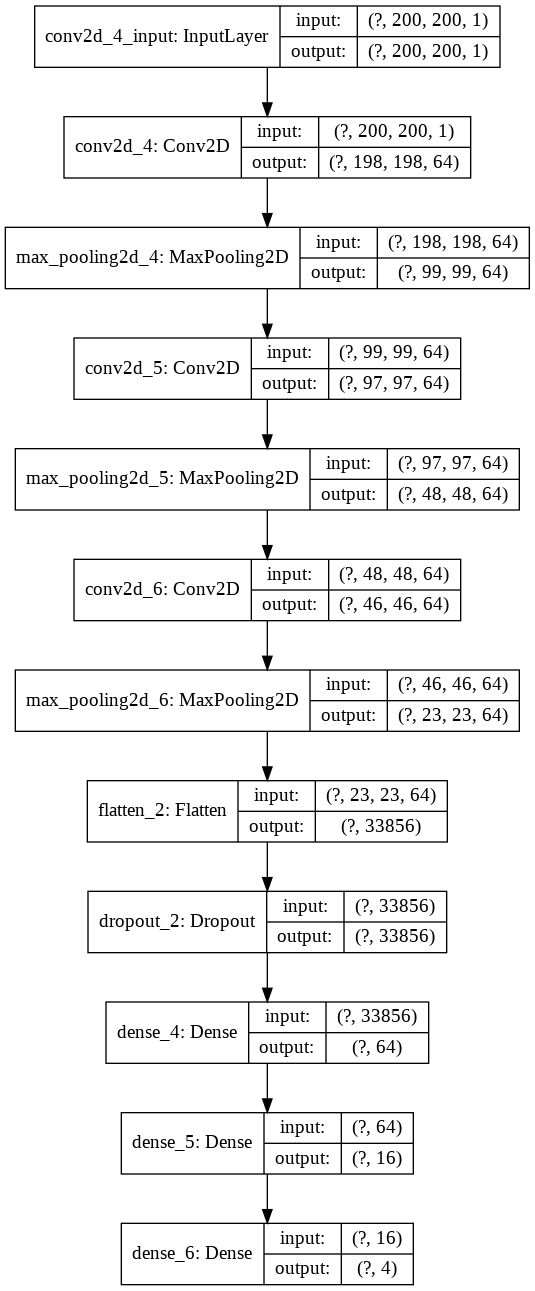

In [0]:
model7=build_model_CNN1(64, 3, 0.5)
history7=model7.fit(X_train2, y_train2, epochs=50,validation_data=(X_val2,y_val2))
model7.summary()
camadas(model7)
output_metrics(model7,history7,X_test2, y_test2)
model_save_name = 'model7.sav'
path = F"/content/{model_save_name}" 
torch.save(model7, path)
tf.keras.utils.plot_model(model7, "model7.png", show_shapes = True)

In [0]:
#model8=build_model_CNN2(32,3,0)
#model8.summary()
#history8=model8.fit(X_train2, y_train2, epochs=50,validation_data=(X_val2,y_val2),callbacks = callbacks)

#camadas(model8)
#output_metrics(model8,history8,X_test2, y_test2)
#model_save_name = 'model8.sav'
#path = F"/content/{model_save_name}" 
#torch.save(model8, path)
#tf.keras.utils.plot_model(model8, "model8.png", show_shapes = True)

In [0]:
#model9=build_model_CNN2(32,3,0.2)
#model9.summary()
#history9=model9.fit(X_train2, y_train2, epochs=50,validation_data=(X_val2,y_val2),callbacks = callbacks)
#camadas(model9)
#output_metrics(model9,history9,X_test2, y_test2)
#model_save_name = 'model9.sav'
#path = F"/content/{model_save_name}" 
#torch.save(model9, path)
#tf.keras.utils.plot_model(model9, "model9.png", show_shapes = True)

In [0]:
#model10=build_model_CNN3()
#history10=model10.fit(X_train2, y_train2, epochs=50,validation_data=(X_val2,y_val2),callbacks = callbacks)
#model10.summary()
#camadas(model10)
#output_metrics(model10,history10,X_test2, y_test2)
#model_save_name = 'model10.sav'
#path = F"/content/{model_save_name}" 
#torch.save(model10, path)
#tf.keras.utils.plot_model(model10, "model10.png", show_shapes = True)

In [0]:
#model_CNN_API_1_3=build_model_CNN_API_1()
#history_model_CNN_API_1_3=model_CNN_API_1_3.fit(X_train2, y_train2, epochs=50,validation_data=(X_val2,y_val2))
#model_CNN_API_1_3.summary()
##camadas(model_CNN_API_1)
#output_metrics(model_CNN_API_1_3,history_model_CNN_API_1_3,X_test2, y_test2)
#model_save_name = 'model_CNN_API_1_3.sav'
#path = F"/content/{model_save_name}" 
#torch.save(model_CNN_API_1_3, path)
#tf.keras.utils.plot_model(model_CNN_API_1_3, "model_CNN_API_1_3.png", show_shapes = True)

In [0]:
#model_CNN_API_2_3=build_model_CNN_API_2()
#history_model_CNN_API_2_3=model_CNN_API_2_3.fit(X_train2, y_train2, epochs=50,validation_data=(X_val2,y_val2))
#model_CNN_API_2_3.summary()
##camadas(model_CNN_API_2)
#output_metrics(model_CNN_API_2_3,history_model_CNN_API_2_3,X_test2, y_test2)
#model_save_name = 'model_CNN_API_2_3.sav'
#path = F"/content/{model_save_name}" 
#torch.save(model_CNN_API_2_3, path)
#tf.keras.utils.plot_model(model_CNN_API_2_3, "model_CNN_API_2_3.png", show_shapes = True

### 12. Previsão Covid-19 
Para o modelo apresentado na secção anterior, visualizam-se agora as classificações COVID-19 corretas e incorretas, de modo a perceber as ineficiências da aprendizagem.

#### 12.1 Identificação correta
De seguida apresentam-se imagens COVID-19 classificadas como tal pelo modelo.

COVID-19 bem identificado:  867 RX em 893


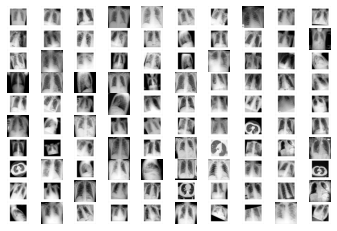

In [0]:
y_pred_3class=np.argmax(model7.predict(X_test2),axis=1)
index1=[]
for i in range(0,len(y_test2),1):
  #if y_test[i] != y_pred1_3classb[i]:#erros totais
  if (y_test2[i] ==0 & y_test2[i] == y_pred_3class[i]):#COVID correto
    #print(i, y_test[i],y_pred1_3classb[i])
    index1.append(i)
i_ = 0
plt.subplots_adjust(wspace=0, hspace=0)
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
print('COVID-19 bem identificado: ', len(index1) , 'RX em',len(np.where(y_test2==0)[0]))
for l in index1[:100]:
    #print(l)    
    plt.subplot(10, 10, i_+1) #.set_title(l)
    i_ += 1
    im = X_test[l]
    im = im[:,:,0]
    plt.imshow(im, cmap="gray")
    plt.axis('off')
    #print(y_pred1_3classb[i]) 

#### 12.2 Identificado como outra pneumonia
De seguida apresentam-se imagens COVID-19 classificadas como outro tipo de pneumonia. Apesar de um erro, não é dos mais graves.

COVID-19 identificado como outra pneumonia:  19 RX em 893


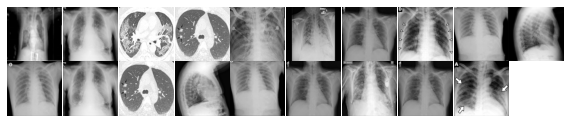

In [0]:
y_pred_3class=np.argmax(model7.predict(X_test2),axis=1)
index1=[]
for i in range(0,len(y_test2),1):
  #if y_test[i] != y_pred1_3classb[i]:#erros totais
  if ((y_test2[i] ==0) & (y_pred_3class[i] in (1,2))):#erro no COVID
    #print(i, y_test[i],y_pred1_3classb[i])
    index1.append(i)
i_ = 0
plt.subplots_adjust(wspace=0, hspace=0)
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
print('COVID-19 identificado como outra pneumonia: ', len(index1) , 'RX em',len(np.where(y_test2==0)[0]))
for l in index1[:169]:
    #print(l)    
    plt.subplot(10, 10, i_+1) #.set_title(l)
    i_ += 1
    im = X_test[l]
    im = im[:,:,0]
    plt.imshow(im, cmap="gray")
    plt.axis('off')
    #print(y_pred1_3classb[i]) 

* algumas das imagens Covid não identificadas aparecem numa postura atípica num RX, assim como com má qualidade.
* Porém, o erro mais grave é marcar o COVID-19 como uma situação normal (**apenas 5 casos**, representados nas imagens seguintes.

#### 12.3 Identificado como normal
Esta última secção apresenta imagens COVID-19 classificadas como normais. Este é o erro mais grave do modelo, incidindo apenas em 25 das 881 imagens (2,8%) Covid-19 no conjunto de teste.

COVID-19 marcado como normal:


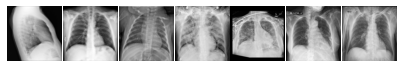

In [0]:
index2=[]
for i in range(0,len(y_test2),1):
  if ((y_test2[i] ==0) & (y_pred_3class[i]==3)):#erro COVID-> normal
    index2.append(i)

plt.subplots_adjust(wspace=0, hspace=0)
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
print('COVID-19 marcado como normal:')
for l in index2[:169]:
    #print(i_)    
    plt.subplot(10, 10, i_+1) #.set_title(l)
    i_ += 1
    im = X_test2[l]
    im = im[:,:,0]
    plt.imshow(im, cmap="gray")
    plt.axis('off')


* apenas 7 das imagens COVID-19 são marcadas como normais.


### 13. Otimização de hiperparâmetros

O último modelo, que classifica imagens COVID, normais e outros tipos de pneumonia, apresenta uma performance interessante (96%). Efetuar-se-á nesta secção um processo de **otimização de hipermparâmetros**, de modo a aumentar este valor.

Começamos por definir a função que alojará as várias topologias (convolucionais e pooling) e taxa de dropout:

In [0]:
def setup_model(topo_c, topo_p, dropout_rate, input_size, output_size):
  model = Sequential()
  model.add(Conv2D(topo_c[0], (3, 3), activation='relu', input_shape=(200,200,1)))
  if topo_p[0]==1: model.add(MaxPooling2D((2, 2)))
  if dropout_rate > 0: model.add(Dropout(dropout_rate))
  for i in range(1,len(topo_c)):
    model.add(Conv2D(topo_c[i], (3, 3), activation='relu'))
    if topo_p[i]==1: model.add(MaxPooling2D((2, 2)))
    if dropout_rate > 0: model.add(Dropout(dropout_rate))
  model.add(layers.Flatten())
  if dropout_rate > 0: model.add(Dropout(dropout_rate))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(4, activation='softmax'))
  return model

Na sequência define-se uma função que incorpora os vários algoritmos de treino, a loss e a métrica a usar, o número de epochs e o batch size:

In [0]:
def train_cnn(model, alg, lr, Xtrain, Ytrain, epochs, batch_size):
  if alg == "adam":
    optimizer = optimizers.Adam(lr = lr)
  elif alg == "rmsprop":
    optimizer = optimizers.RMSprop(lr = lr)
  elif alg == "sgd_momentum":
   optimizer = optimizers.SGD(lr = lr, momentum = 0.9)
  else: optimizer = optimizers.SGD(lr = lr)

  model.compile(optimizer = optimizer, loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
  history=model.fit(Xtrain, Ytrain, epochs = epochs, batch_size = batch_size, verbose = 0)
  return model,history

A última função vai treinando os vários modelos, guardando configuração com a melhor performance:

In [0]:
def cnn_optimization(opt_params, Xtrain, Ytrain, Xval, Yval, iterations, verbose = True):
  #verbose: producing detailed logging information
  from random import choice
  if verbose: print("Topology\tDropout\tAlgorithm\tLRate\tBatchSize\tEpochs\tValLoss\tValAcc\n")
  best_acc = None
  input_size = Xtrain.shape[0]
  output_size = Ytrain.shape[0]

  if "topology_c" in opt_params: topologies_c = opt_params["topology_c"]
  else: topologies_c = [[64,64,64]]
  if "topology_p" in opt_params: topologies_p = opt_params["topology_p"]
  else: topologies_p = [[1,1,1]]
  if "algorithm" in opt_params: algs = opt_params["algorithm"]
  else: algs = ["adam"]
  if "lr" in opt_params: lrs = opt_params["lr"]
  else: lrs = [0.001]
  if "dropout" in opt_params: dropouts = opt_params["dropout"]
  else: dropouts= [0.0]
  if "batch_size" in opt_params: batch_sizes = opt_params["batch_size"]
  else: batch_sizes= [512]
  if "epochs" in opt_params: epoch = opt_params["epochs"]
  else: epoch= [5]

  for it in range(iterations):
    #print('Iteração', it+1, 'de', iterations)
    #random item from the list
    topo_c = choice(topologies_c)
    topo_p = choice(topologies_p)   
    dropout_rate = choice(dropouts)
    dnn = setup_model (topo_c,topo_p, dropout_rate, input_size, output_size)
    alg = choice(algs)
    lr = choice(lrs)
    bs=choice(batch_sizes)
    epo=choice(epoch)

    dnn, history = train_cnn(dnn, alg, lr, Xtrain, Ytrain, epo, bs)
    val_loss, val_acc = dnn.evaluate(Xval, Yval, verbose = 0)
    if verbose:
      print(topo_c, "\t", topo_p, "\t", dropout_rate, "\t", alg, "\t", lr, "\t", bs, "\t", epo, "\t", val_loss, "\t", val_acc)
    if best_acc is None or val_acc > best_acc:
      best_acc = val_acc
      best_config = (topo_c, topo_p, dropout_rate, alg, lr, bs, epo)
      best_model=dnn
      best_history=history
    return best_config, best_acc,best_model,best_history

In [0]:
def cnn_optimization(opt_params, Xtrain, Ytrain, Xval, Yval, iterations, verbose = True):
  #verbose: producing detailed logging information
  from random import choice
  if verbose: print("Topology\tDropout\tAlgorithm\tLRate\tBatchSize\tEpochs\tValLoss\tValAcc\n")
  best_acc = None
  input_size = Xtrain.shape[0]
  output_size = Ytrain.shape[0]

  if "topology_c" in opt_params: topologies_c = opt_params["topology_c"]
  else: topologies_c = [[64,64,64]]
  if "topology_p" in opt_params: topologies_p = opt_params["topology_p"]
  else: topologies_p = [[1,1,1]]
  if "algorithm" in opt_params: algs = opt_params["algorithm"]
  else: algs = ["adam"]
  if "lr" in opt_params: lrs = opt_params["lr"]
  else: lrs = [0.001]
  if "dropout" in opt_params: dropouts = opt_params["dropout"]
  else: dropouts= [0.0]
  if "batch_size" in opt_params: batch_sizes = opt_params["batch_size"]
  else: batch_sizes= [512]
  if "epochs" in opt_params: epoch = opt_params["epochs"]
  else: epoch= [5]

  for it in range(iterations):
    #print('Iteração', it+1, 'de', iterations)
    #random item from the list
    topo_c = choice(topologies_c)
    topo_p = choice(topologies_p)   
    dropout_rate = choice(dropouts)
    dnn = setup_model (topo_c,topo_p, dropout_rate, input_size, output_size)
    alg = choice(algs)
    lr = choice(lrs)
    bs=choice(batch_sizes)
    epo=choice(epoch)

    dnn, history = train_cnn(dnn, alg, lr, Xtrain, Ytrain, epo, bs)
    val_loss, val_acc = dnn.evaluate(Xval, Yval, verbose = 0)
    #if verbose:
    print(topo_c, "\t", topo_p, "\t", dropout_rate, "\t", alg, "\t", lr, "\t", bs, "\t", epo, "\t", val_loss, "\t", val_acc)
    #config = (topo_c, topo_p, dropout_rate, alg, lr, bs, epo, val_loss, val_acc)
    if best_acc is None or val_acc > best_acc:
      best_acc = val_acc
      best_config = (topo_c, topo_p, dropout_rate, alg, lr, bs, epo)

      best_model=dnn
      best_history=history
  print("\t")
  print("BestTopology\tBestDropout\tBestAlgorithm\tBestLRate\tBestBatchSize\tBestEpochs\tBestValLoss\tBestValAcc\n")
  print(best_config, "\t", best_acc)
  return best_config, best_acc,best_model,best_history

Listam-se os hiperparâmetros a otimizar:

In [0]:
opt_pars = {
     "topology_c":[[64,64,64], [32,64,128], [64,64,64,128,128]],
     "topology_p":[[1,1,1,1,1], [1,0,1,0,1]],#pooling constante ou intercalado
     "algorithm": ["adam","RMSprop"],
     "lr": [0.001, 0.0001], 
     "dropout": [0, 0.2],
     "batch_size":  [64],
     "epochs":[10]}

E inicia-se o treino dos modelos e a seleção do mais preditivo:

In [0]:
best_config, best_val_acc,best_model,best_history=cnn_optimization(opt_pars, X_train2, y_train2, X_val2, y_val2, 30,verbose = True)

Topology	Dropout	Algorithm	LRate	BatchSize	Epochs	ValLoss	ValAcc

[64, 64, 64] 	 [1, 1, 1, 1, 1] 	 0.2 	 RMSprop 	 0.001 	 64 	 10 	 0.42191598491561144 	 0.8689581155776978
[64, 64, 64] 	 [1, 0, 1, 0, 1] 	 0 	 adam 	 0.0001 	 64 	 10 	 0.0999392097621804 	 0.9683136343955994
[32, 64, 128] 	 [1, 1, 1, 1, 1] 	 0.2 	 RMSprop 	 0.001 	 64 	 10 	 0.3945994138013407 	 0.8807733654975891
[32, 64, 128] 	 [1, 1, 1, 1, 1] 	 0 	 adam 	 0.001 	 64 	 10 	 0.11089550425267501 	 0.9645542502403259
[32, 64, 128] 	 [1, 0, 1, 0, 1] 	 0 	 adam 	 0.001 	 64 	 10 	 0.10875602011897958 	 0.9688506722450256
[64, 64, 64] 	 [1, 1, 1, 1, 1] 	 0.2 	 RMSprop 	 0.001 	 64 	 10 	 0.45062296916795724 	 0.8598281145095825
[64, 64, 64, 128, 128] 	 [1, 1, 1, 1, 1] 	 0.2 	 adam 	 0.0001 	 64 	 10 	 0.2924237377085312 	 0.896885097026825
[64, 64, 64] 	 [1, 0, 1, 0, 1] 	 0 	 RMSprop 	 0.001 	 64 	 10 	 0.31507826546081025 	 0.8861439228057861
[64, 64, 64] 	 [1, 1, 1, 1, 1] 	 0 	 adam 	 0.001 	 64 	 10 	 0.097649960505559

Das hipóteses testadas, identifica-se como mais preditivo um modelo com:
* 3 camadas convolucionais de 32, 64 e 128 filtros, seguida de uma camada de pooling após a primeira camada convolucional e após a última
* ausência de dropout
* algoritmo de treino: Adam
* velocidade de aprendizagem: 0.001

Para os parâmetros ótimos de algoritmo, batch-size e learning-rate selecionados, testam-se algumas topologias adicionais:

In [0]:
opt_pars = {
     "topology_c":[[64,64],[64,64,64], [32,32,32], [128,128,128], [32,64,128], [64,64,64,128,128]],
     "topology_p":[[1,1,1,1,1], [1,0,1,0,1]],#pooling constante ou intercalado
     "algorithm": ["adam"],
     "lr": [0.001], 
     "dropout": [0, 0.2],
     "batch_size":  [64],
     "epochs":[10]
     }

In [0]:
best_config, best_val_acc,best_model,best_history= cnn_optimization(opt_pars, X_train2, y_train2, X_val2, y_val2, 10,verbose = True)

Topology	Dropout	Algorithm	LRate	BatchSize	Epochs	ValLoss	ValAcc

[64, 64] 	 [1, 0, 1, 0, 1] 	 0 	 adam 	 0.001 	 64 	 10 	 0.13236986217914284 	 0.9667024612426758
[64, 64, 64] 	 [1, 0, 1, 0, 1] 	 0 	 adam 	 0.001 	 64 	 10 	 0.17179744286716753 	 0.9597207307815552
[32, 32, 32] 	 [1, 1, 1, 1, 1] 	 0.2 	 adam 	 0.001 	 64 	 10 	 0.11697988783506523 	 0.9602577686309814
[128, 128, 128] 	 [1, 0, 1, 0, 1] 	 0 	 adam 	 0.001 	 64 	 10 	 0.1327368199713248 	 0.9613319039344788
[128, 128, 128] 	 [1, 1, 1, 1, 1] 	 0.2 	 adam 	 0.001 	 64 	 10 	 0.12811174671836878 	 0.9602577686309814
[64, 64] 	 [1, 0, 1, 0, 1] 	 0 	 adam 	 0.001 	 64 	 10 	 0.14250091850636556 	 0.9645542502403259
[32, 64, 128] 	 [1, 0, 1, 0, 1] 	 0.2 	 adam 	 0.001 	 64 	 10 	 0.11921694694701122 	 0.9575725197792053
[64, 64] 	 [1, 1, 1, 1, 1] 	 0 	 adam 	 0.001 	 64 	 10 	 0.08648698460150642 	 0.9790548086166382
[32, 32, 32] 	 [1, 0, 1, 0, 1] 	 0.2 	 adam 	 0.001 	 64 	 10 	 0.13544029279118833 	 0.9543501734733582
[64, 

Nesta otimização, variou o número de camadas convolucionais: de 64+64+64 para 64+64.

Treina-se de seguida a melhor configuração identificada para o modelo num conjunto de dados que engloba os dados de treino e validação.

In [0]:
#unir treino e validação para uma última corrida com o modelo ótimo
X_train_total=np.append(X_train2,X_val2)
y_train_total=np.append(y_train2,y_val2)
X_train_total=X_train_total.reshape(X_train2.shape[0]+X_val2.shape[0],200,200,1)
y_train_total=y_train_total.reshape(y_train2.shape[0]+y_val2.shape[0],)
print(X_train2.shape )
print(X_val2.shape )
print(X_train_total.shape)
print(y_train_total.shape)

(4342, 200, 200, 1)
(1862, 200, 200, 1)
(6204, 200, 200, 1)
(6204,)


In [0]:
print("Best configuration:", best_config)
print("Best validation accuracy:", best_val_acc)
best_model = setup_model(best_config[0], best_config[1],best_config[2], X_train2.shape[0],y_train2.shape[0])
best_model, best_history = train_cnn(best_model, best_config[3], best_config[4], X_train_total,y_train_total,best_config[5],50)
test_loo, test_acc = best_model.evaluate(X_test2, y_test2, verbose = 0)
print("Test set metrics:", test_loo, test_acc)

Best configuration: ([64, 64], [1, 1, 1, 1, 1], 0, 'adam', 0.001, 64, 10)
Best validation accuracy: 0.9790548086166382
Test set metrics: 0.22429909469856513 0.9751786589622498


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 198, 198, 64)      640       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 99, 99, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 97, 97, 64)        36928     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 147456)            0         
_________________________________________________________________
dense_37 (Dense)             (None, 64)                9437248   
_________________________________________________________________
dense_38 (Dense)             (None, 16)              

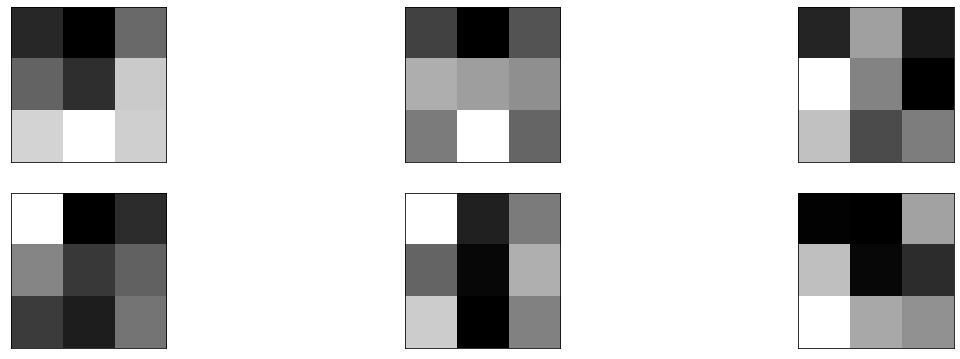

Predicted    0    1    2
Actual                  
0          883    3    7
1            3  873   34
2            1   18  837
accuracy total: 0.9751786385859346
precision covid: 0.9954904171364148
recall covid: 0.9888017917133258
precision total: 0.9751011485087117
recall total: 0.9753153964572473
label precision recall
    0     0.995  0.989
    1     0.977  0.959
    2     0.953  0.978
2659/2659 [==============================] - 3s 1ms/step
[0.22429909469856513, 0.9751786589622498]


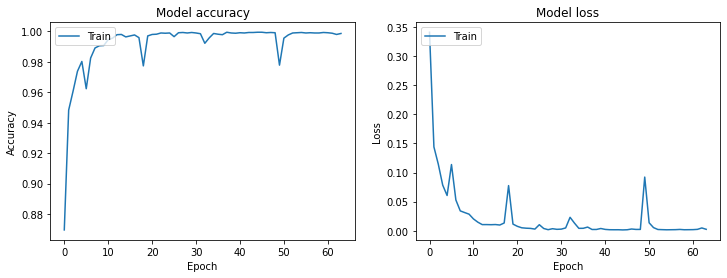

In [0]:
best_model.summary()
camadas(best_model)
output_metrics2(best_model,best_history,X_test2, y_test2)

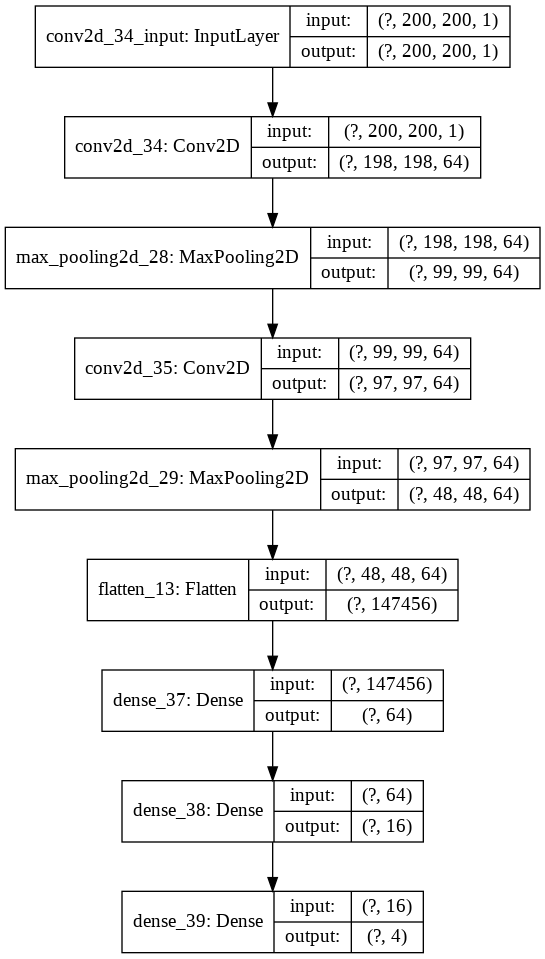

In [0]:
model_save_name = 'best_model.sav'
path = F"/content/{model_save_name}" 
torch.save(best_model, path)
tf.keras.utils.plot_model(best_model, "best_model.png", show_shapes = True)

O modelo dinal, avaliado no conjunto de teste, apresenta uma **performance global de 98%**, identificando **99% dos casos COVID-19**.

O maior erro está associado a pacientes com pneumonia viral ou bacteriana classificados como normais (28 casos). 

Destaque para a visualização dos 3 casos de COVID-19 marcados como normais:

COVID-19 marcado como normal:


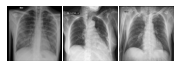

In [0]:

y_pred_3class2=np.argmax(best_model.predict(X_test2),axis=1)

index2=[]
for i in range(0,len(y_test2),1):
  if ((y_test2[i] ==0) & (y_pred_3class2[i]==3)):#erro COVID-> normal
    index2.append(i)

plt.subplots_adjust(wspace=0, hspace=0)
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
print('COVID-19 marcado como normal:')
for l in index2[:169]:
    #print(i_)    
    plt.subplot(10, 10, i_+1) #.set_title(l)
    i_ += 1
    im = X_test2[l]
    im = im[:,:,0]
    plt.imshow(im, cmap="gray")
    plt.axis('off')

Não se identifica nas imagens motivo, à priori, para a dificuldade na classificação. Eventualmente poder-se-ia avaliar clinicamente a label atribuída a estes casos.

### 14. Machine learning com label de 3 classes

De modo a comparar a performande de modelos de ML e DL com o mesmo número de labels a prever, treinou-se mais um modelo de ML.

In [0]:
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_all_vec,y_all2, test_size = 0.3,random_state=10)

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1,p=1, weights='uniform')
knn_model_3=knn.fit(X_train_4, y_train_4)
print(knn_model_3)
Y_pred_test = knn_model_3.predict(X_test_4)

conf_mat=confusion_matrix(y_test_4,knn.predict(X_test_4))
conf_mat=pd.DataFrame(conf_mat)
conf_mat.index.name='Actual'
conf_mat.columns.name='Predicted'
knn_model_score=knn_model.score(X_test_4, y_test_4)
print(conf_mat)
print('Score:',knn_model_score)
model_save_name = 'knn_model_3.sav'
path = F"/content/{model_save_name}" 
torch.save(knn_model_3, path)

### 15. API funcional
### 15.1 Versão 1

In [0]:
visible = Input(shape=(200,200,1))
# first feature extractor
conv1 = Conv2D(64, kernel_size=4, activation='relu')(visible)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, kernel_size=4, activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(64, kernel_size=4, activation='relu')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
flat1 = Flatten()(pool3)
# second feature extractor

conv2_1 = Conv2D(32, kernel_size=4, activation='relu')(visible)
pool2_1 = AveragePooling2D(pool_size=(2, 2))(conv2_1)
conv2_2 = Conv2D(32, kernel_size=4, activation='relu')(pool2_1)
pool2_2 = AveragePooling2D(pool_size=(2, 2))(conv2_2)
conv2_3 = Conv2D(32, kernel_size=4, activation='relu')(pool2_2)
pool2_2 = AveragePooling2D(pool_size=(2, 2))(conv2_3)
flat2 = Flatten()(pool2_2)
# merge feature extractors
merge = concatenate([flat1, flat2])
# interpretation layer
hidden1 = Dense(128, activation='relu')(merge)
hidden2 = Dense(64, activation='relu')(hidden1)
hidden3 = Dense(32, activation='relu')(hidden2)    
# prediction output
output = Dense(4, activation='softmax')(hidden3)
model8 = Model(inputs=visible, outputs=output)
model8.compile(optimizers.Adam(lr=0.00001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history8=model8.fit(X_train2, y_train2, epochs=50,validation_data=(X_val2,y_val2))

Train on 4342 samples, validate on 1862 samples
Epoch 1/50
4342/4342 [==============================] - 33s 8ms/step - loss: 0.9483 - accuracy: 0.6278 - val_loss: 0.5872 - val_accuracy: 0.8147
Epoch 2/50
4342/4342 [==============================] - 31s 7ms/step - loss: 0.4648 - accuracy: 0.8455 - val_loss: 0.3842 - val_accuracy: 0.8818
Epoch 3/50
4342/4342 [==============================] - 31s 7ms/step - loss: 0.3411 - accuracy: 0.8895 - val_loss: 0.3087 - val_accuracy: 0.8996
Epoch 4/50
4342/4342 [==============================] - 31s 7ms/step - loss: 0.2785 - accuracy: 0.9083 - val_loss: 0.2661 - val_accuracy: 0.9017
Epoch 5/50
4342/4342 [==============================] - 31s 7ms/step - loss: 0.2462 - accuracy: 0.9171 - val_loss: 0.2387 - val_accuracy: 0.9227
Epoch 6/50
4342/4342 [==============================] - 31s 7ms/step - loss: 0.2247 - accuracy: 0.9226 - val_loss: 0.2150 - val_accuracy: 0.9280
Epoch 7/50
4342/4342 [==============================] - 31s 7ms/step - loss: 0.201

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 1)  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 197, 197, 64) 1088        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 197, 197, 32) 544         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_30 (MaxPooling2D) (None, 98, 98, 64)   0           conv2d_36[0][0]                  
____________________________________________________________________________________________

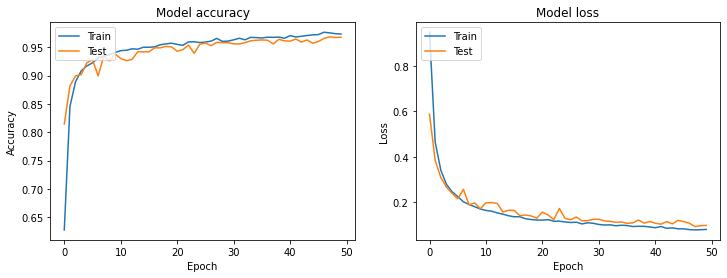

In [0]:
model8.summary()
output_metrics(model8,history8,X_test2, y_test2)

In [0]:
model_save_name = 'model8.sav'
path = F"/content/{model_save_name}" 
torch.save(model8, path)

A primeira API funcional resulta numa precisão de 96%.

### 15.2 Versão 2

In [0]:
visible = Input(shape=(200,200,1))
# first feature extractor
conv1 = Conv2D(64, kernel_size=4, activation='relu')(visible)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, kernel_size=4, activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(64, kernel_size=4, activation='relu')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
flat1 = Flatten()(pool3)
# second feature extractor

conv2_1 = Conv2D(32, kernel_size=4, activation='relu')(visible)
pool2_1 = AveragePooling2D(pool_size=(2, 2))(conv2_1)
conv2_2 = Conv2D(32, kernel_size=4, activation='relu')(pool2_1)
pool2_2 = AveragePooling2D(pool_size=(2, 2))(conv2_2)
conv2_3 = Conv2D(32, kernel_size=4, activation='relu')(pool2_2)
pool2_2 = AveragePooling2D(pool_size=(2, 2))(conv2_3)
flat2 = Flatten()(pool2_2)
# merge feature extractors
merge = concatenate([flat1, flat2])
# interpretation layer
hidden1 = Dense(128, activation='relu')(merge)
hidden2 = Dense(64, activation='relu',)(hidden1)
hidden3 = Dense(32, activation='relu')(hidden2)
hidden4 = Dense(16, activation='relu')(hidden3)
hidden5 = Dense(32, activation='relu')(hidden4)
hidden6 = Dense(16, activation='relu')(hidden5)
hidden7 = Dense(8, activation='relu')(hidden6)

hidden1_1 = Dense(128, activation='relu')(merge)
hidden2_1 = Dense(64, activation='relu')(hidden1_1)
hidden3_1 = Dense(32, activation='relu')(hidden2_1)
hidden4_1 = Dense(32, activation='relu')(hidden3_1)
concatenated = concatenate([hidden3, hidden4_1])
output = Dense(4, activation='sigmoid')(concatenated)
model9 = Model(inputs=visible, outputs=output)

model9.compile(optimizers.Adam(lr=0.00001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history9=model9.fit(X_train2, y_train2, epochs=50,validation_data=(X_val2,y_val2))

Train on 4342 samples, validate on 1862 samples
Epoch 1/50
4342/4342 [==============================] - 32s 7ms/step - loss: 0.9805 - accuracy: 0.6393 - val_loss: 0.6098 - val_accuracy: 0.7266
Epoch 2/50
4342/4342 [==============================] - 32s 7ms/step - loss: 0.4077 - accuracy: 0.8588 - val_loss: 0.3414 - val_accuracy: 0.8593
Epoch 3/50
4342/4342 [==============================] - 32s 7ms/step - loss: 0.2754 - accuracy: 0.9056 - val_loss: 0.2541 - val_accuracy: 0.9071
Epoch 4/50
4342/4342 [==============================] - 32s 7ms/step - loss: 0.2333 - accuracy: 0.9199 - val_loss: 0.2155 - val_accuracy: 0.9221
Epoch 5/50
4342/4342 [==============================] - 32s 7ms/step - loss: 0.2116 - accuracy: 0.9240 - val_loss: 0.2010 - val_accuracy: 0.9280
Epoch 6/50
4342/4342 [==============================] - 32s 7ms/step - loss: 0.1881 - accuracy: 0.9378 - val_loss: 0.1834 - val_accuracy: 0.9334
Epoch 7/50
4342/4342 [==============================] - 32s 7ms/step - loss: 0.184

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 200, 200, 1)  0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 197, 197, 64) 1088        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 197, 197, 32) 544         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_33 (MaxPooling2D) (None, 98, 98, 64)   0           conv2d_42[0][0]                  
____________________________________________________________________________________________

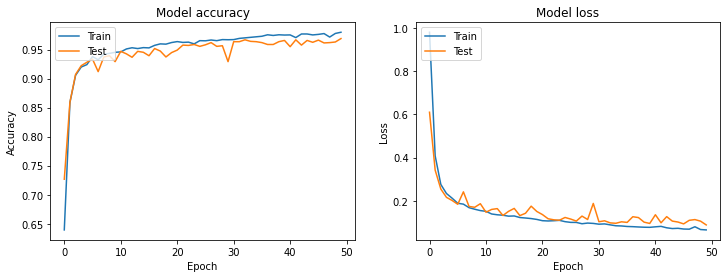

In [0]:
model9.summary()
output_metrics(model9,history9,X_test2, y_test2)

model_save_name = 'model9.sav'
path = F"/content/{model_save_name}" 
torch.save(model9, path)

O modelo apresenta uma performance de 97%.

### 15.3 Versão 3

In [0]:
visible = Input(shape=(200,200,1))
# first feature extractor
conv1 = Conv2D(64, kernel_size=3, activation='relu')(visible)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, kernel_size=3, activation='relu')(pool1)
conv3 = Conv2D(64, kernel_size=3, activation='relu')(conv2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
flat1 = Flatten()(pool3)

# second feature extractor
conv2_1 = Conv2D(64, kernel_size=3, activation='relu')(visible)
batc2_1= BatchNormalization()(conv2_1)
pool2_1 = MaxPooling2D(pool_size=(2, 2))(batc2_1)
drop2_1=Dropout(0.5)(pool2_1)
conv2_2 = Conv2D(64, kernel_size=3, activation='relu')(drop2_1)
batc2_2= BatchNormalization()(conv2_2)
conv2_3 = Conv2D(64, kernel_size=3, activation='relu')(batc2_2)
batc2_3= BatchNormalization()(conv2_3)
pool2_2 = MaxPooling2D(pool_size=(2, 2))(batc2_3)
drop2_2=Dropout(0.5)(pool2_2)
conv2_4 = Conv2D(128, kernel_size=4, activation='relu')(drop2_2)
batc2_3= BatchNormalization()(conv2_4)
conv2_5 = Conv2D(128, kernel_size=4, activation='relu')(batc2_3)
batc2_4= BatchNormalization()(conv2_5)
pool2_3 = MaxPooling2D(pool_size=(2, 2))(batc2_4)
drop2_3=Dropout(0.5)(pool2_3)

flat2 = Flatten()(pool2_3)
# merge feature extractors
merge = concatenate([flat1, flat2])
# interpretation layer
drop2_4=Dropout(0.5)(merge)
hidden1 = Dense(128, activation='relu')(drop2_4)
hidden2 = Dense(64, activation='relu')(hidden1)
hidden3 = Dense(32, activation='relu')(hidden2)    
# prediction output
output = Dense(4, activation='softmax')(hidden3)
model10 = Model(inputs=visible, outputs=output)
model10.compile(optimizers.Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history10=model10.fit(X_train2, y_train2, epochs=50,validation_data=(X_val2,y_val2))

Train on 4342 samples, validate on 1862 samples
Epoch 1/50
4342/4342 [==============================] - 95s 22ms/step - loss: 0.8915 - accuracy: 0.8344 - val_loss: 3.3810 - val_accuracy: 0.5789
Epoch 2/50
4342/4342 [==============================] - 93s 21ms/step - loss: 0.2156 - accuracy: 0.9302 - val_loss: 4.8103 - val_accuracy: 0.5999
Epoch 3/50
4342/4342 [==============================] - 93s 21ms/step - loss: 0.1750 - accuracy: 0.9417 - val_loss: 3.2759 - val_accuracy: 0.5140
Epoch 4/50
4342/4342 [==============================] - 93s 21ms/step - loss: 0.1193 - accuracy: 0.9606 - val_loss: 0.7960 - val_accuracy: 0.7390
Epoch 5/50
4342/4342 [==============================] - 93s 21ms/step - loss: 0.0979 - accuracy: 0.9687 - val_loss: 1.2502 - val_accuracy: 0.7154
Epoch 6/50
4342/4342 [==============================] - 92s 21ms/step - loss: 0.1081 - accuracy: 0.9661 - val_loss: 0.4755 - val_accuracy: 0.8985
Epoch 7/50
4342/4342 [==============================] - 93s 21ms/step - loss

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 200, 200, 1)  0                                            
__________________________________________________________________________________________________
conv2d_51 (Conv2D)              (None, 198, 198, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 198, 198, 64) 256         conv2d_51[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_38 (MaxPooling2D) (None, 99, 99, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

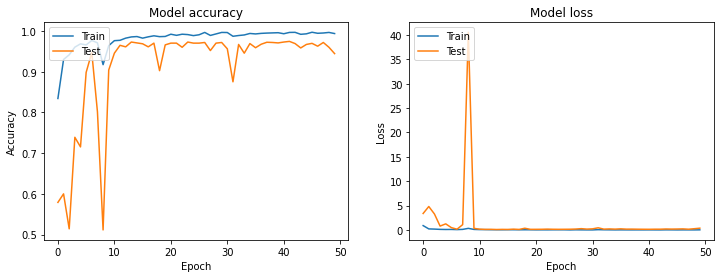

In [0]:
model10.summary()
output_metrics(model10,history10,X_test2, y_test2)

In [0]:
model_save_name = 'model10.sav'
path = F"/content/{model_save_name}" 
torch.save(model10, path)

As 3 API funcionais do Keras apresentam resultados semelhantes

### 16. Transfer learning


In [0]:
from keras.applications import VGG19, InceptionResNetV2
#Inception-ResNet-v2 combines the advantages of Inception networks and residual connections to achieve state-of-the-art accuracy on the ILSVRC image classification benchmark

In [0]:
InceptionResNetV2 = InceptionResNetV2(weights=None, include_top=False,	input_tensor=Input(shape=(200, 200, 1)))
print(InceptionResNetV2.summary())

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 200, 200, 1)  0                                            
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 99, 99, 32)   288         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 99, 99, 32)   96          conv2d_56[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 99, 99, 32)   0           batch_normalization_6[0][0]      
________________________________________________________________________________

In [0]:
headModel = InceptionResNetV2.output
headModel = MaxPooling2D(pool_size=(2, 2))(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Flatten()(headModel)
headModel=Dense(64,activation='relu')(headModel) 
headModel = Dropout(0.2)(headModel)
headModel=Dense(16,activation='relu')(headModel) 
headModel = Dropout(0.2)(headModel)
headModel=Dense(4,activation='softmax')(headModel)
model11 = Model(inputs=InceptionResNetV2.input, outputs=headModel)

In [0]:
model11.compile(optimizers.Adam(lr=0.001, decay=0.001/ 5),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history11=model11.fit(X_train2, y_train2, epochs=50,validation_data=(X_val2,y_val2),callbacks = callbacks)

Train on 4342 samples, validate on 1862 samples
Epoch 1/50
4342/4342 [==============================] - 318s 73ms/step - loss: 0.5242 - accuracy: 0.7874 - val_loss: 1.2902 - val_accuracy: 0.3367
Epoch 2/50
4342/4342 [==============================] - 237s 55ms/step - loss: 0.3289 - accuracy: 0.8998 - val_loss: 1.8257 - val_accuracy: 0.3426
Epoch 3/50
4342/4342 [==============================] - 237s 55ms/step - loss: 0.2462 - accuracy: 0.9187 - val_loss: 1.2278 - val_accuracy: 0.6536
Epoch 4/50
4342/4342 [==============================] - 237s 55ms/step - loss: 0.2143 - accuracy: 0.9422 - val_loss: 0.6788 - val_accuracy: 0.7148
Epoch 5/50
4342/4342 [==============================] - 237s 55ms/step - loss: 0.2685 - accuracy: 0.9162 - val_loss: 0.4326 - val_accuracy: 0.8668
Epoch 6/50
4342/4342 [==============================] - 237s 54ms/step - loss: 0.2033 - accuracy: 0.9456 - val_loss: 0.3334 - val_accuracy: 0.9130
Epoch 7/50
4342/4342 [==============================] - 237s 54ms/step

In [0]:
model_save_name = 'model11.sav'
path = F"/content/{model_save_name}" 
torch.save(model11, path)

Predicted    0    1    2
Actual                  
0          889    1    3
1            4  885   21
2            2   23  831
accuracy total: 0.9796916133884919
precision covid: 0.9932960893854749
recall covid: 0.9955207166853304
precision total: 0.979607757894284
recall total: 0.9796141939120558
label precision recall
    0     0.993  0.996
    1     0.974  0.973
    2     0.972  0.971
2659/2659 [==============================] - 34s 13ms/step
[0.12469846741641333, 0.9796916246414185]


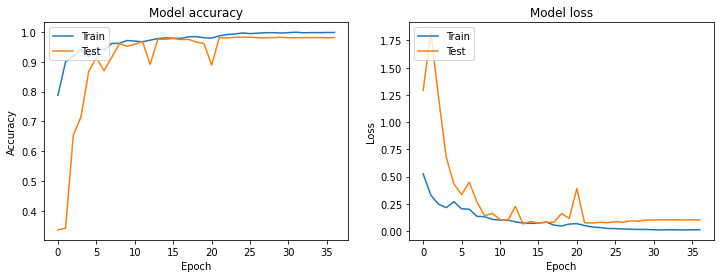

In [0]:
output_metrics(model11,history11,X_test2, y_test2)

In [0]:
test_loss, test_acc = model11.evaluate(X_test2, y_test2, verbose = 0)
print("Test set metrics:", test_loss, test_acc)

Test set metrics: 0.12469846741641333 0.9796916246414185


### 17. Visualização de resultados

Esta secção apresenta visualizações das convoluções e da aprendizagem feita pelos modelo.

Começamos por selecionar uma imagem Covid-19 para analisar.

In [0]:
def covid_image():
  for j in range(1,len(y_test),1):
    if (y_test[j]==0): #covid19
        cov_index=j
        break
  return cov_index

In [0]:
#select Covid19 image
cov_index=covid_image()
# load the image with the required shape
img_covid=X_all[cov_index]
img_covid.shape


(200, 200, 1)

#### 17.1 Imagem original e convolucionada

In [0]:
from scipy.signal import convolve2d
import numpy as np 
import cv2
from matplotlib import pyplot as plt

def convolved_image(kernel, img):
    convolved = convolve2d(img, kernel)
    fig = plt.figure(figsize=(15, 15))
    plt.subplot(121)
    plt.title('Original image')
    plt.axis('off')
    plt.imshow(np.real(img), cmap='gray')
 
    plt.subplot(122)
    plt.title('Convolved image')
    plt.axis('off')
    plt.imshow(convolved, cmap='gray')
    return convolved

In [0]:
img_covid2 = img_covid.reshape(200,200)
img_covid2.shape

(200, 200)

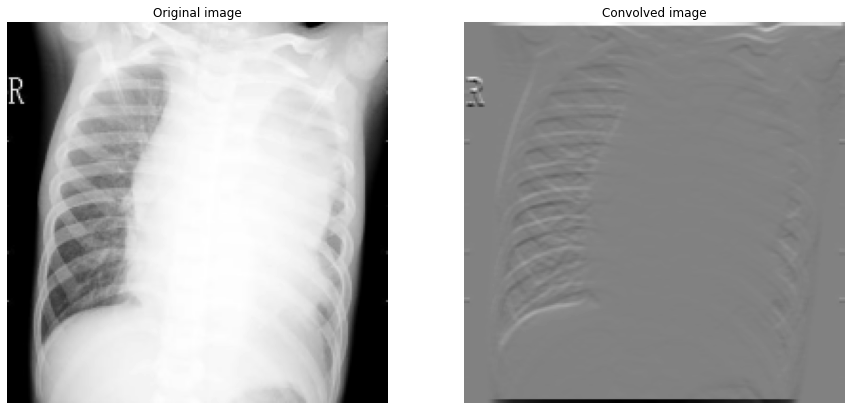

In [0]:
# edges horizontais
kernel = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]], np.float32)
output = convolved_image(kernel, img_covid2)

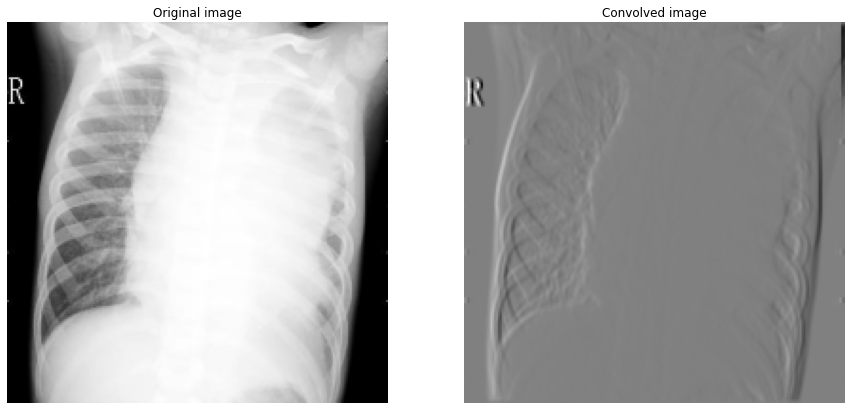

In [0]:
# edges verticais
kernel = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]], np.float32)
output = convolved_image(kernel, img_covid2)

#### 17.2 Hidden layers

In [0]:
#select model
model=model11

(1, 200, 200, 1)


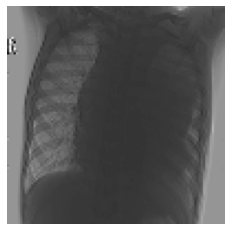

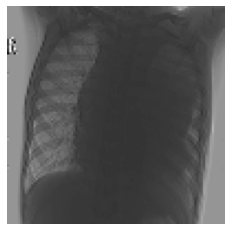

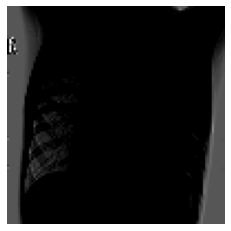

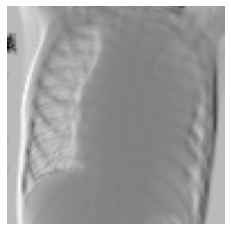

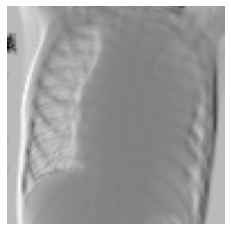

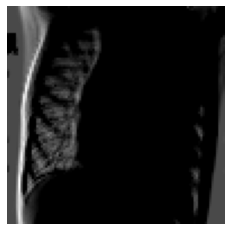

In [0]:
# load the model
# redefine model to output right after the first hidden layer
ixs = [1, 2, 3, 4, 5, 6]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)

img_covid=X_all[cov_index]
#expanded dimensions from a 3D array to a 4D array with the dimensions of [samples, rows, cols, channels], where we only have one sample.
img_covid3 = expand_dims(img_covid, axis=0)
print(img_covid3.shape)
#get the feature map for first hidden layer: calling the model.predict() function and passing in the prepared single image.
feature_maps = model.predict(img_covid3)

# plot the output from each block
for fmap in feature_maps:
  ix = 1
  ax = plt.subplot(1, 1, ix)                          
  plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
  plt.axis('off')
  ix += 1
  plt.show()

### 16. Comparação de resultados

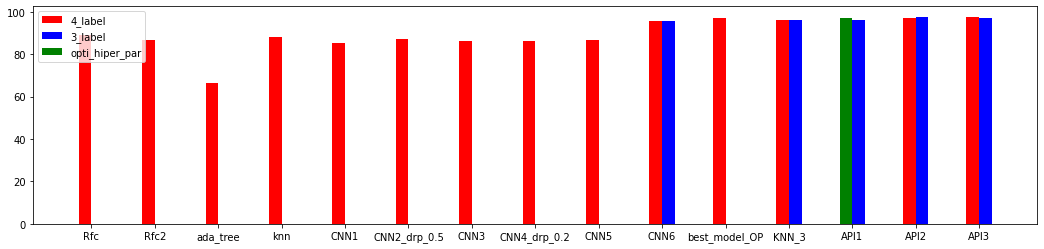

In [0]:
Rfc=Accuracy_total_Rfc
Rfc2=scores_rf2_mean
ada=scores_ada_mean
knn=knn_model_score
CNN1=((history1.history['accuracy'])[-1])*100
CNN1_drp_0_5=((history2.history['accuracy'])[-1])*100
CNN2=((history3.history['accuracy'])[-1])*100
CNN2_drp_0_2=((history4.history['accuracy'])[-1])*100
CNN3=((history5.history['accuracy'])[-1])*100
CNN_API_1=((history_model_CNN_API_1.history['accuracy'])[-1])*100
CNN_API_2=((history_model_CNN_API_2.history['accuracy'])[-1])*100

CNN1_3=((history6.history['accuracy'])[-1])*100
CNN1_drp_0_5_3=((history7.history['accuracy'])[-1])*100
CNN2_3=((history8.history['accuracy'])[-1])*100
CNN2_drp_0_2_3=((history9.history['accuracy'])[-1])*100
CNN3_3=((history10.history['accuracy'])[-1])*100
CNN_API_1_3=((history_model_CNN_API_1_3.history['accuracy'])[-1])*100
CNN_API_2_3=((history_model_CNN_API_2_3.history['accuracy'])[-1])*100
best_model=((best_history.history['accuracy'])[-1])*100

plt.figure(figsize=(35,15))
#ind = np.arange(15)
ind = np.arange(12)
width = 0.2

labels = ['RFC','RFC2','ADA','KNN','CNN1', 'CNN1_drp_0.5', 'CNN2', 'CNN2_drp_0.2','CNN3','CNN_API_1','CNN_API_2','Best_model_op_hip_par']
bar_08 = plt.bar(ind, [Rfc,Rfc2,ada,knn,CNN1,CNN1_drp_0_5,CNN2,CNN2_drp_0_2,CNN3,CNN_API_1,CNN_API_2,0], width, color='r', label='4_label')
bar_18 = plt.bar(ind+width, [0,0,0,0,CNN1_3, CNN1_drp_0_5_3, CNN2_3, CNN2_drp_0_2_3, CNN3_3, CNN_API_1_3, CNN_API_2_3,best_model], width, color='b', label='3_label')
#bar_28 = plt.bar(ind, [0, 0, 0, 0, 0, 0, 0,], width, color='g', label='opti_hiper_par')

location = ind+width/2
labels=labels
plt.xticks(location, labels)
plt.legend(loc='best')# 85.22

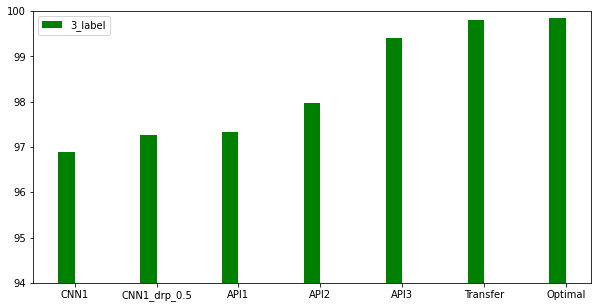

In [0]:
#knn=knn_model_score

CNN1=((history6.history['accuracy'])[-1])*100
CNN1_drp_0_5_3=((history7.history['accuracy'])[-1])*100
API1=((history8.history['accuracy'])[-1])*100
API2=((history9.history['accuracy'])[-1])*100
API3=((history10.history['accuracy'])[-1])*100
Transfer=((history11.history['accuracy'])[-1])*100
Optimal=((best_history.history['accuracy'])[-1])*100

plt.figure(figsize=(10,5))
#ind = np.arange(15)
ind = np.arange(7)
width = 0.2

labels = ['CNN1', 'CNN1_drp_0.5', 'API1', 'API2','API3','Transfer','Optimal']
bar_08 = plt.bar(ind, [CNN1,CNN1_drp_0_5_3,API1,API2,API3,Transfer,Optimal],width, color='g', label='3_label')
location = ind+width/2
labels=labels
plt.xticks(location, labels)
axes = plt.gca()
axes.set_ylim([94,100])
plt.legend(loc='best')

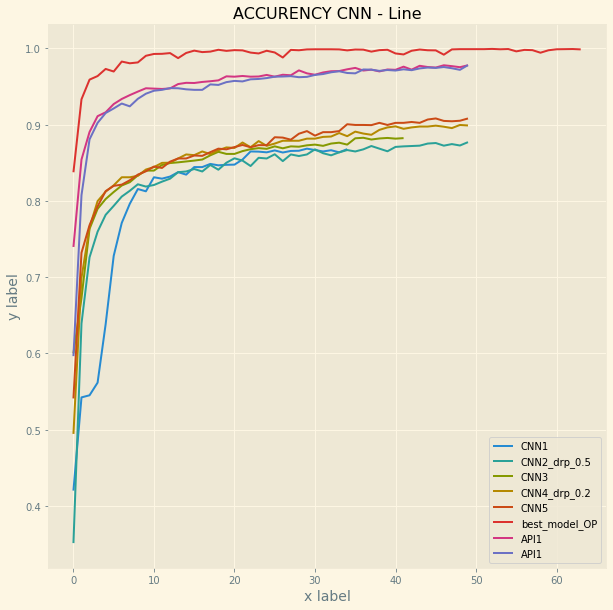

In [0]:
with plt.style.context('Solarize_Light2'):
    plt.plot((history1.history['accuracy']),label='CNN1_4')
    plt.plot((history2.history['accuracy']),label='CNN1_drp_0_5_4')
    plt.plot((history3.history['accuracy']),label='CNN2_4')
    plt.plot((history4.history['accuracy']),label='CNN2_drp_0_2_4')
    plt.plot((history5.history['accuracy']),label='CNN3_4')
    plt.plot((history_model_CNN_API_1.history['accuracy']),label='CNN_API_1_4')
    plt.plot((history_model_CNN_API_2.history['accuracy']),label='CNN_API_2_4')

    plt.plot((history6.history['accuracy']),label='CNN1_3')
    plt.plot((history7.history['accuracy']),label='CNN1_drp_0_5_3')
    plt.plot((history8.history['accuracy']),label='CNN2_3')
    plt.plot((history9.history['accuracy']),label='CNN2_drp_0_2_3')
    plt.plot((history10.history['accuracy']),label='CNN3_3')
    plt.plot((history_model_CNN_API_1_3.history['accuracy']),label='CNN_API_1_3')
    plt.plot((history_model_CNN_API_2_3.history['accuracy']),label='CNN_API_2_3')
    plt.plot((best_history.history['accuracy']),label='best_model_3')

    '''
    plt.plot((history2.history['accuracy']),label='CNN2_drp_0.5')
    plt.plot((history3.history['accuracy']),label='CNN3')
    plt.plot((history4.history['accuracy']),label='CNN4_drp_0.2')
    plt.plot((history5.history['accuracy']),label='CNN5')
   # plt.plot((history6.history['accuracy']),label='CNN6')
    plt.plot((best_history.history['accuracy']),label='best_model_OP')
    plt.plot((history8.history['accuracy']),label='API1')
    plt.plot((history9.history['accuracy']),label='API2')
   # plt.plot((history10.history['accuracy']),label='API3_10_Epoch')    
    # Number of accent colors in the color scheme
    '''
    plt.title('ACCURACY CNN - Line')
    plt.xlabel('# epochs', fontsize=14)
    plt.ylabel('accuracy', fontsize=14)
    ax = plt.subplot(111)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.legend(loc='best')

plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


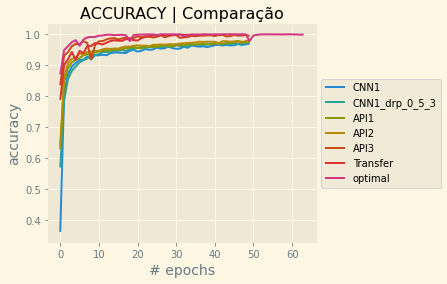

In [0]:
with plt.style.context('Solarize_Light2'):
    plt.plot((history6.history['accuracy']),label='CNN1')
    plt.plot((history7.history['accuracy']),label='CNN1_drp_0_5_3')
    plt.plot((history8.history['accuracy']),label='API1')
    plt.plot((history9.history['accuracy']),label='API2')
    plt.plot((history10.history['accuracy']),label='API3')
    plt.plot((history11.history['accuracy']),label='Transfer')
    plt.plot((best_history.history['accuracy']),label='optimal')

    plt.title('ACCURACY | Comparação')
    plt.xlabel('# epochs', fontsize=14)
    plt.ylabel('accuracy', fontsize=14)
    ax = plt.subplot(111)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.legend(loc='best')

plt.show()